https://www.kaggle.com/c/porto-seguro-data-challenge

###### Acessar https://drive.google.com/drive/folders/1jFo7K5X749N8LzF-SuDBD-zB1YGXJqjs?usp=sharing

Clicar em "Adicionar Atalho ao Google Drive"

In [ ]:
path_notebook = '/content/drive/MyDrive/Desafio_Kaggle/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
#drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
import os
import sys
sys.path.insert(0, os.path.dirname(path_notebook))

In [ ]:
import AleTransforms as trf
import AleDatasetAnalysis as dat
import AleMLAnalysis as aml
import AleExplainers as exp
import AleLearners as lrn

In [ ]:
import importlib
importlib.reload(trf)
importlib.reload(dat)
importlib.reload(aml)
importlib.reload(exp)
importlib.reload(lrn)

<module 'AleLearners' from '/content/drive/MyDrive/Desafio_Kaggle/AleLearners.py'>

# Acessando API do Kaggle, Download e Extração do Dataset

In [ ]:
#Instala a API
!pip install kaggle

In [ ]:
# Move minhas credenciais para a pasta em que a API foi instalada
!mkdir -p ~/.kaggle/ && cp -i /content/drive/MyDrive/Desafio_Kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

cp: overwrite '/root/.kaggle/kaggle.json'? sim


In [ ]:
#Baixa dos dados do Projeto, descompacta e deleta arquivo zip
!kaggle competitions download -c porto-seguro-data-challenge

submission_sample.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
metadata.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


# Começa a fazer os Trem

In [ ]:
!pip install Catboost

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, KFold

from catboost import CatBoostClassifier 
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

import joblib

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
!ls

drive	      sample_data	     test.csv.zip
metadata.csv  submission_sample.csv  train.csv.zip


In [ ]:
pd.read_csv('metadata.csv')

,Variavel cod,Variavel tipo
0,id,Qualitativo nominal
1,var1,Qualitativo nominal
2,var2,Qualitativo nominal
3,var3,Qualitativo nominal
4,var4,Qualitativo nominal
...,...,...
65,var65,Quantitativo continua
66,var66,Quantitativo continua
67,var67,Quantitativo discreto
68,var68,Quantitativo discreto


In [ ]:
df = pd.read_csv('train.csv.zip')

In [ ]:
df

,id,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,var40,var41,var42,var43,var44,var45,var46,var47,var48,var49,var50,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,y
0,1,18,19,2853,29442,1386,2435,35,-999,3,63,6498,1166,2007,26,13,11,11,4,1547,26,2068,1,3,0,4,7,0,24,4,2,0,16,3,44,463,27,2,0,4,9,3,25,6,1,4,3,1,0,0,0,0,42,1,1,0.212414,0.137,0.833333,0.037822,0.058070,0.311441,0.142303,0.056146,0.632694,0.024054,0.253356,0.00603,0.132353,0.139706,1
1,8,4,110,1986,13684,7189,-999,-999,17,3,63,13989,497,2289,16,1,3,3,3,1797,16,2417,5,1,2,1,6,1,4,2,1,0,14,0,1,532,2,1,0,4,7,3,30,3,0,0,0,0,0,0,0,0,20,1,1,0.228784,0.308,0.305376,0.069325,0.248909,-999.000000,-999.000000,0.070991,0.773966,0.019315,-999.000000,-999.00000,0.147059,0.106618,0
2,30,0,39,1019,10232,678,791,16,-999,3,63,9739,562,641,10,34,34,10,4,511,10,664,5,3,2,1,7,0,3,4,1,0,11,1,3,81,26,3,0,4,3,3,23,5,1,0,0,0,0,0,0,0,12,1,1,0.204636,0.213,0.451613,0.018639,0.214520,-999.000000,0.200814,0.051046,0.980827,0.018536,-999.000000,-999.00000,0.382353,0.242647,0
3,43,20,39,1751,2689,8235,1042,13,10,1,14,2890,6541,811,8,59,60,23,5,624,8,839,0,0,0,0,1,1,19,1,2,0,8,0,11,414,27,0,0,4,10,3,22,10,1,1,1,0,1,1,0,0,36,1,1,0.208299,0.716,0.101075,0.204753,0.349421,-999.000000,0.352379,0.044301,0.951564,0.023684,0.363370,0.00201,0.147059,0.132353,0
4,46,7,44,2262,29428,6031,304,16,-999,3,63,13541,7238,260,10,55,56,20,5,1413,10,270,2,3,2,1,8,1,3,4,1,0,17,4,3,567,8,3,2,4,5,3,26,5,1,0,0,0,0,1,0,0,19,1,1,0.222896,0.596,0.101075,0.140394,0.189641,0.021226,0.226161,0.059125,0.906155,0.020733,-999.000000,-999.00000,0.455882,0.132353,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14118,35295,4,39,2511,28766,1109,2094,31,24,3,-999,5082,-999,1678,23,55,56,20,5,198,23,1739,5,4,2,1,7,0,26,5,1,0,17,5,12,314,0,1,0,4,2,3,23,5,1,0,0,0,0,0,0,0,25,2,2,0.227307,0.048,0.978495,0.063199,0.122448,-999.000000,0.069347,0.036178,0.869828,0.016160,-999.000000,-999.00000,0.455882,0.147059,0
14119,35296,19,129,1114,-999,6376,-999,-999,27,-999,-999,-999,-999,1387,13,-999,-999,-999,-999,719,13,1445,5,1,1,2,-999,0,24,4,1,0,13,6,25,532,27,1,0,4,10,1,26,13,1,0,0,0,0,0,1,0,-999,0,0,0.210104,-999.000,-999.000000,-999.000000,-999.000000,-999.000000,0.295418,0.055899,0.921292,0.018293,-999.000000,-999.00000,0.147059,0.198529,0
14120,35301,27,44,1786,23761,9048,623,35,27,3,14,1249,882,358,26,34,34,10,4,482,26,380,5,3,2,1,7,0,24,4,1,0,17,3,44,362,2,0,0,4,1,3,25,4,1,0,0,0,0,0,0,0,16,2,2,0.217944,0.029,1.000000,0.034263,0.207001,-999.000000,0.203394,0.040697,0.930373,0.009440,-999.000000,-999.00000,0.397059,0.158088,0
14121,35304,4,89,210,19593,3634,2453,35,27,1,63,21128,3849,2033,26,55,56,20,5,1573,26,2093,3,3,0,0,7,0,24,4,2,0,16,2,24,553,0,18,0,4,1,3,28,14,1,0,0,0,0,1,0,1,21,2,2,0.209336,0.154,0.833333,0.022503,0.200405,0.070788,0.381038,0.100384,0.680121,0.041096,-999.000000,-999.00000,0.264706,0.128676,0


In [ ]:
df[df == -999] = np.nan

In [ ]:
analiseexp = dat.DistribuicoesDataset(df, num_div = 10, num_cat = 5)

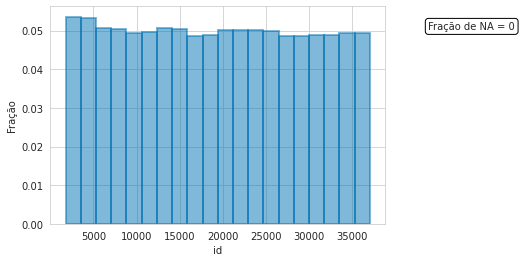

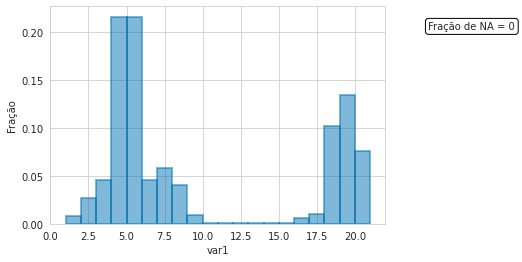

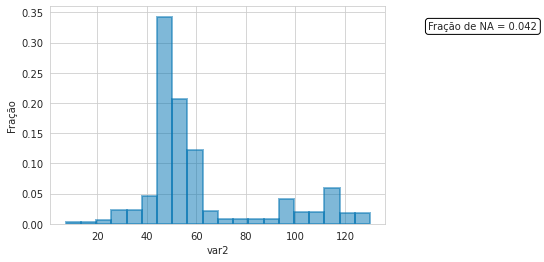

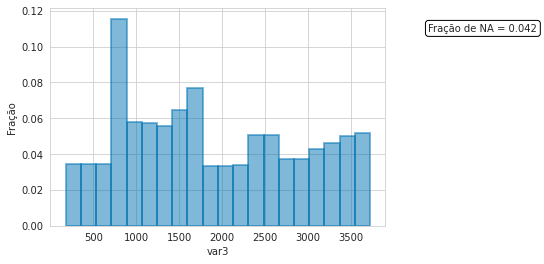

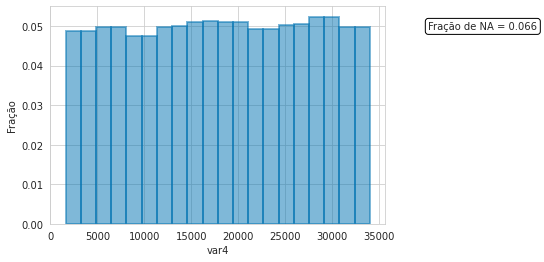

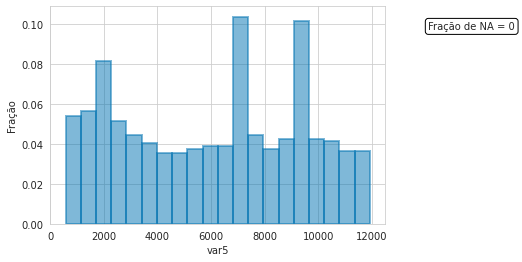

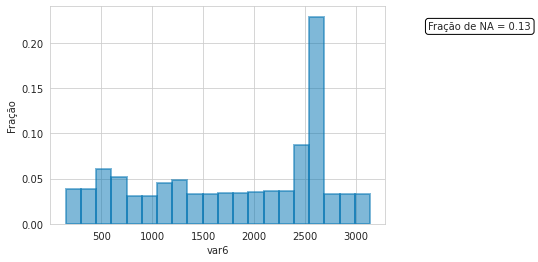

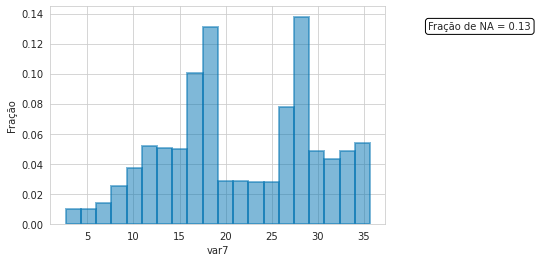

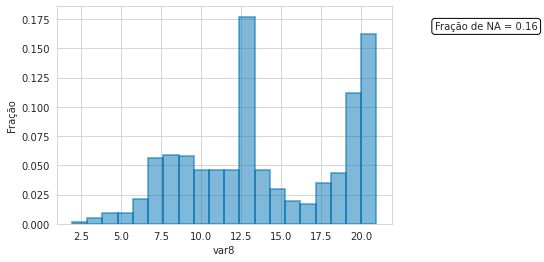

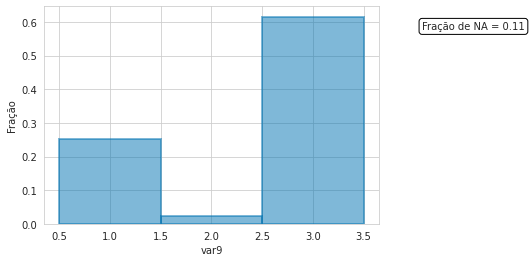

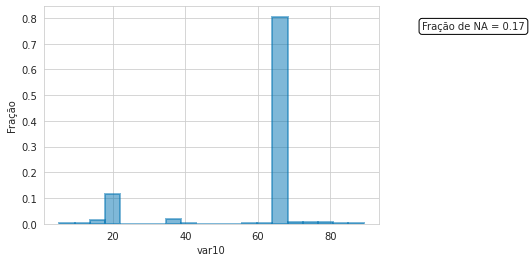

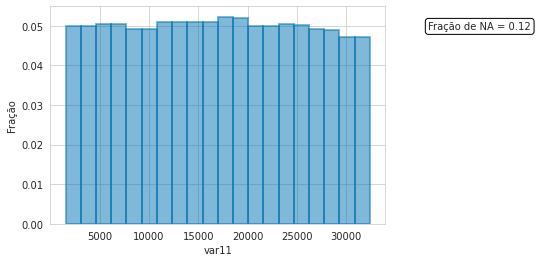

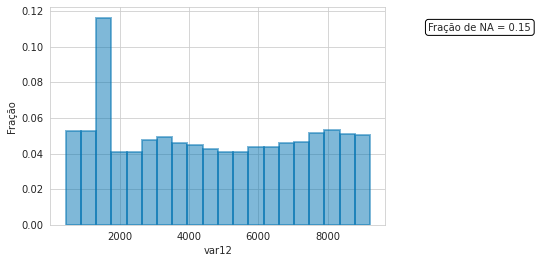

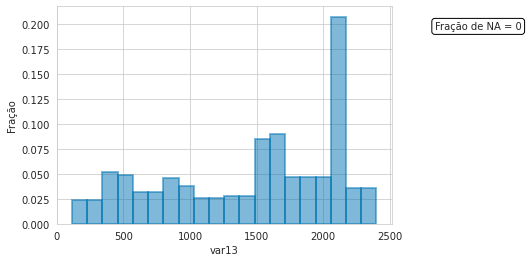

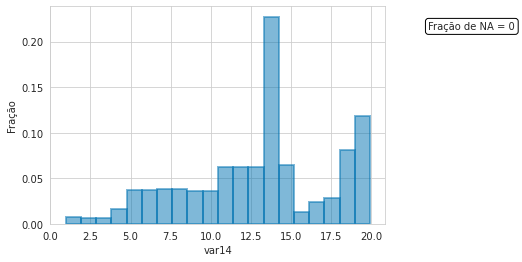

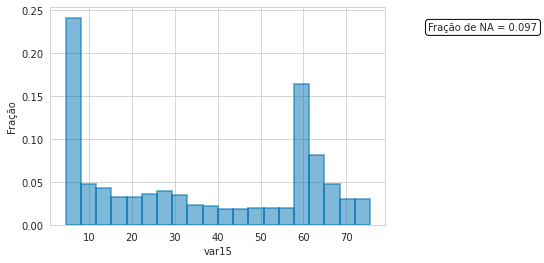

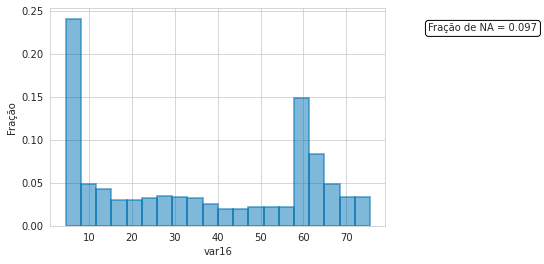

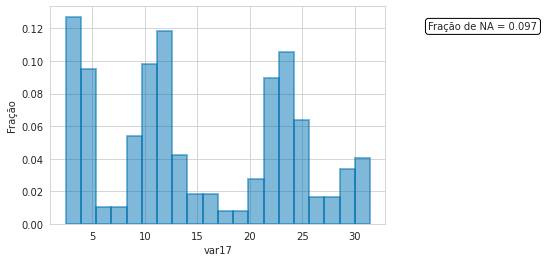

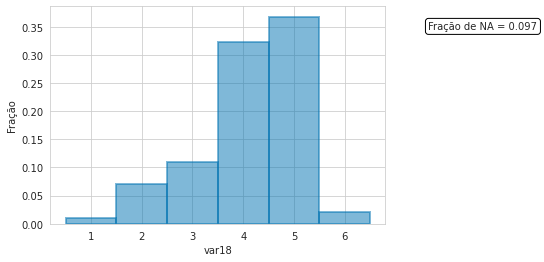

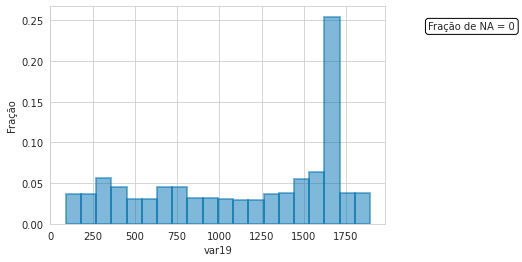

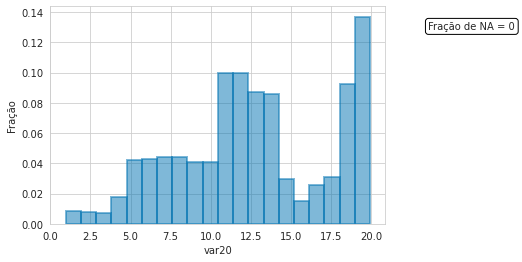

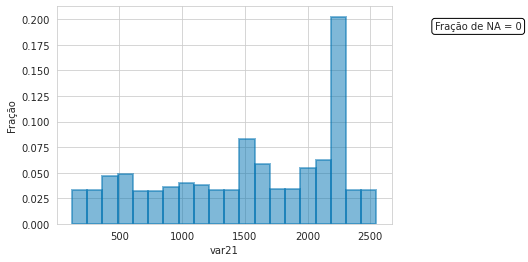

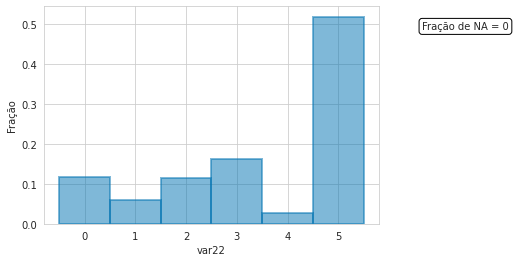

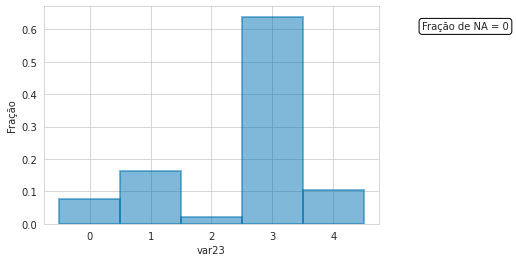

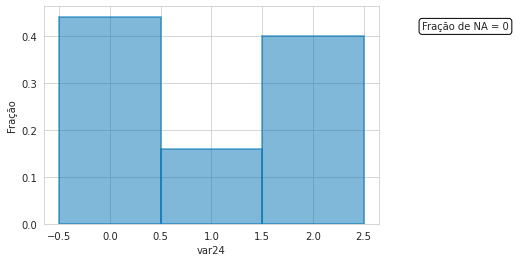

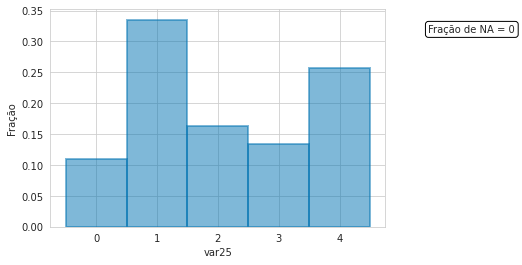

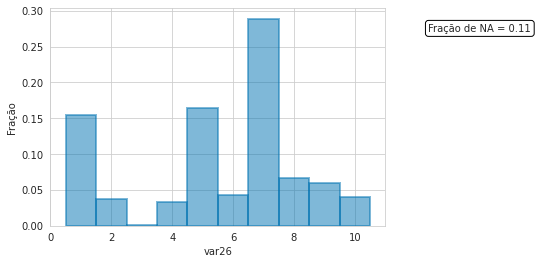

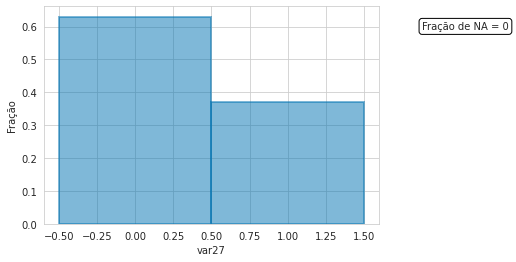

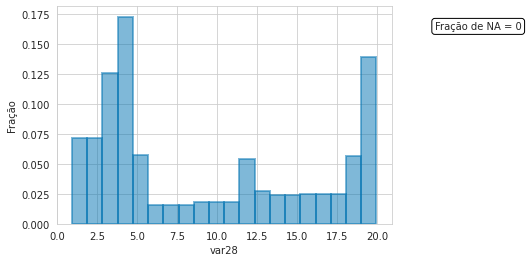

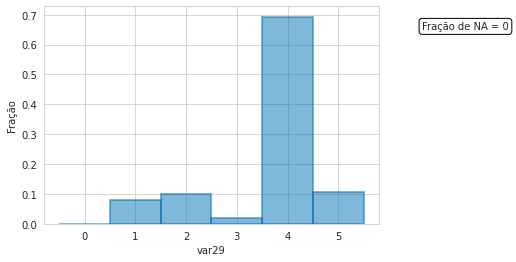

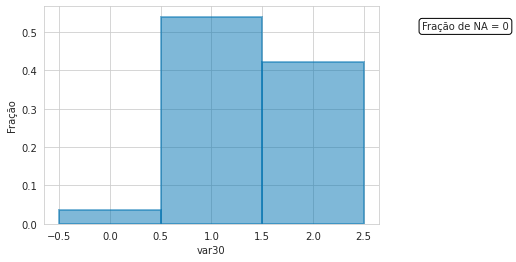

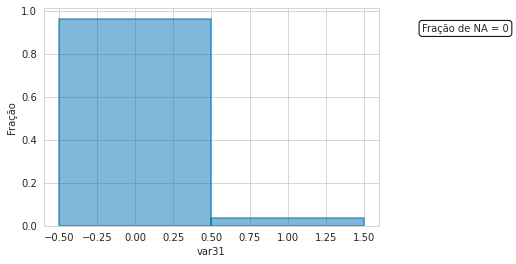

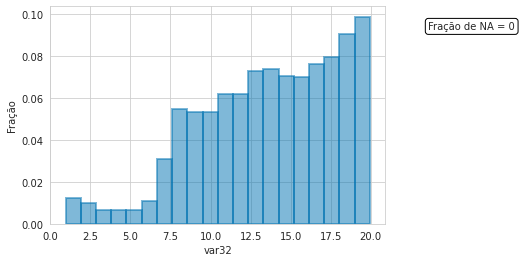

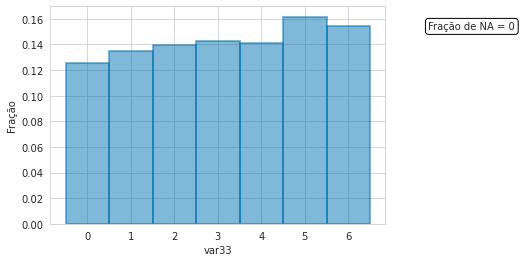

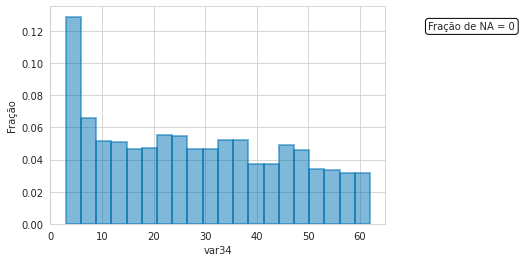

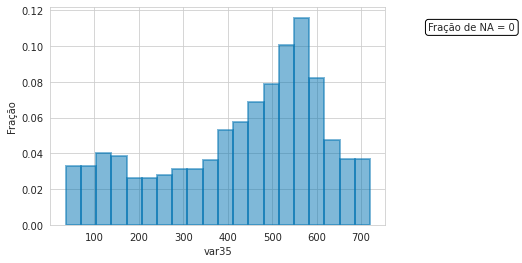

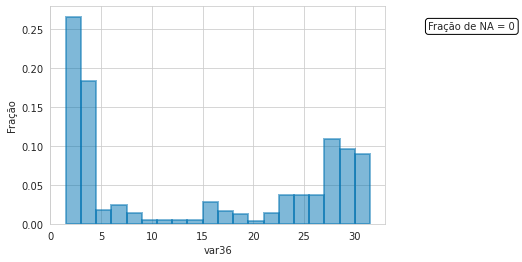

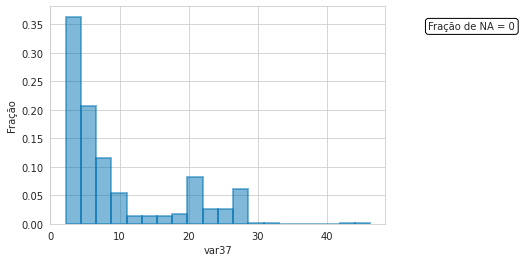

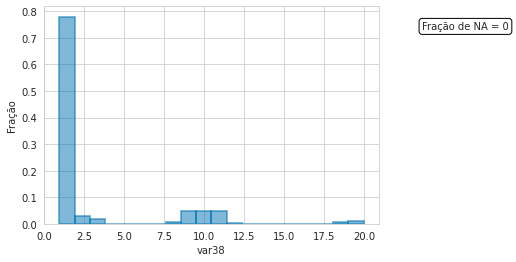

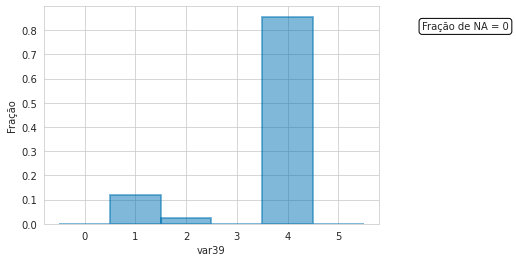

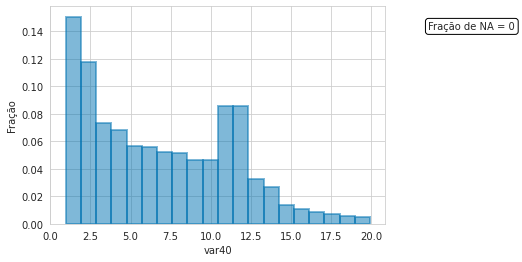

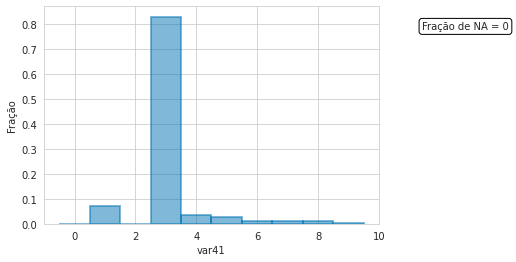

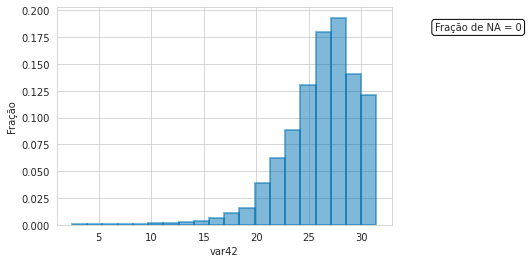

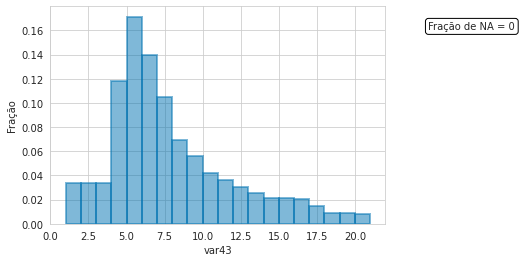

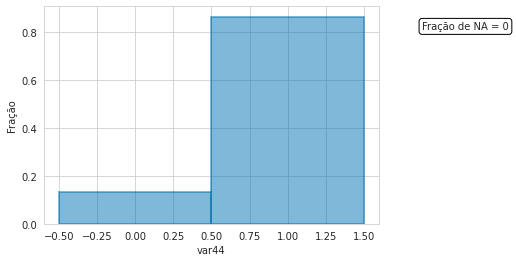

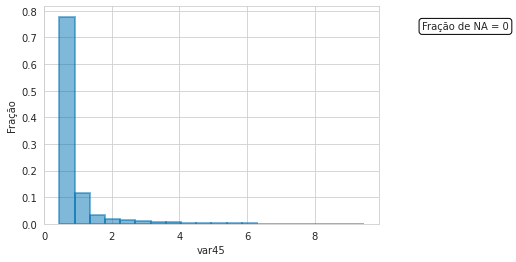

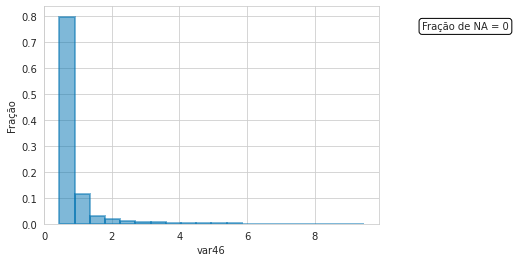

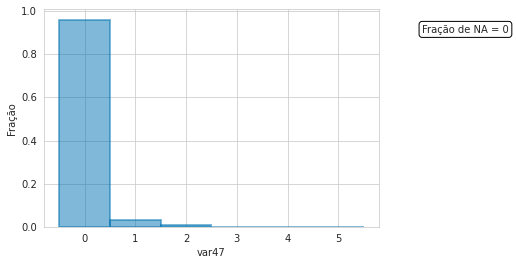

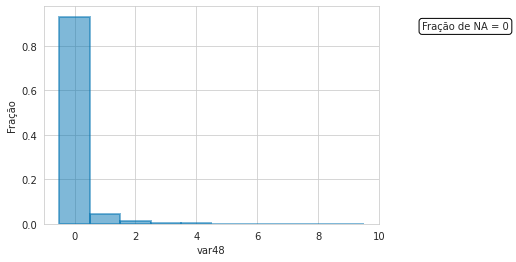

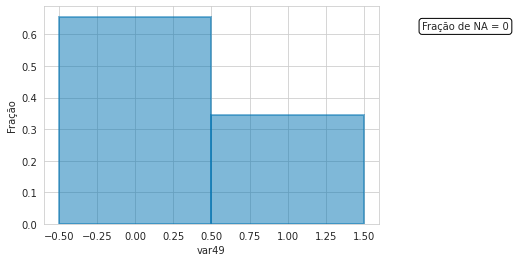

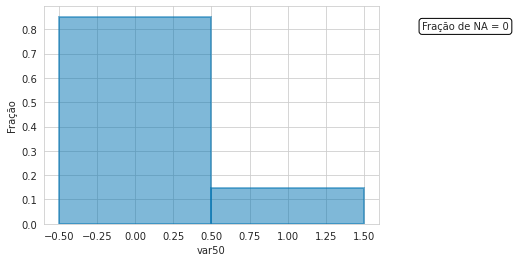

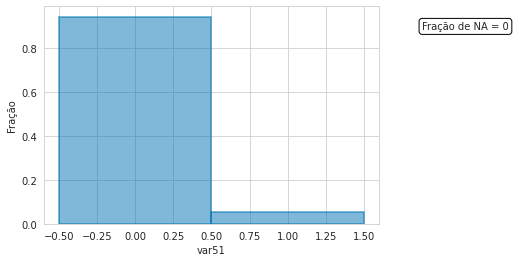

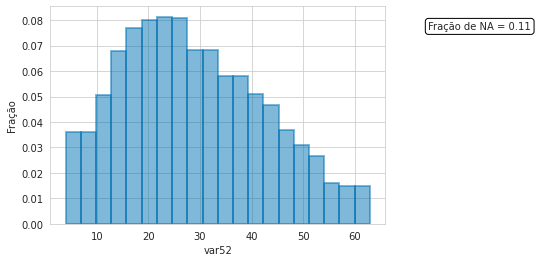

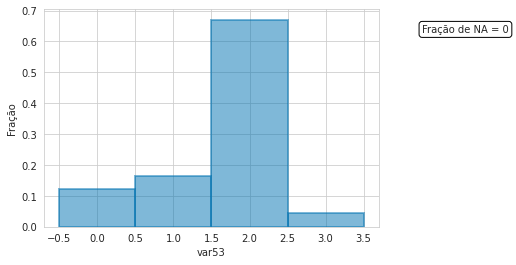

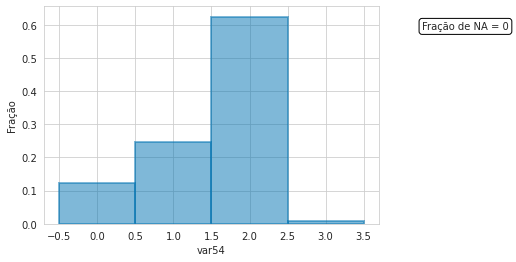

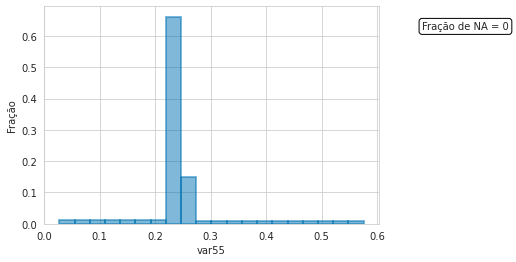

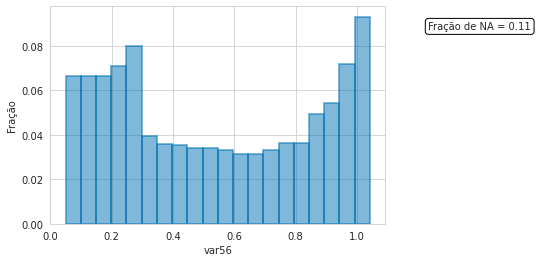

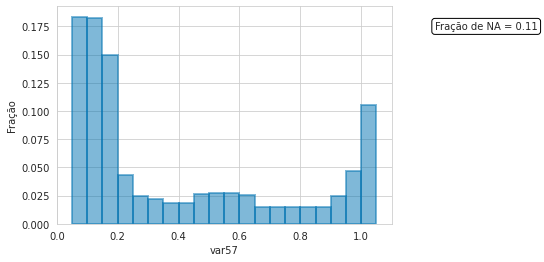

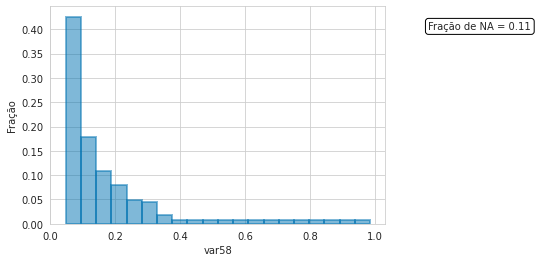

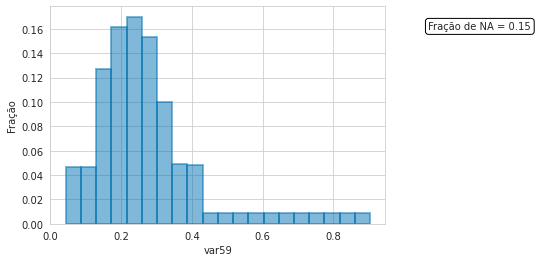

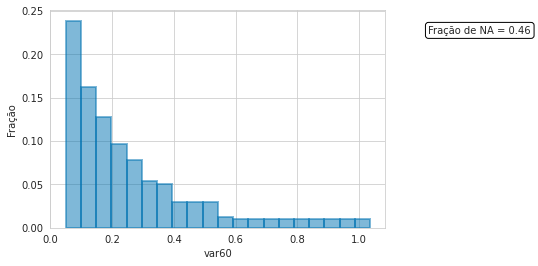

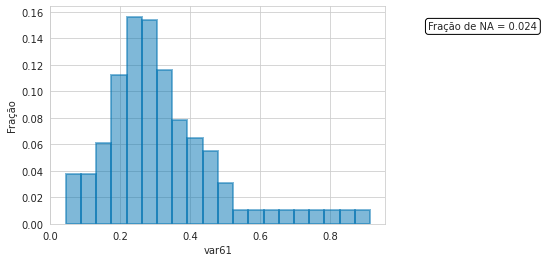

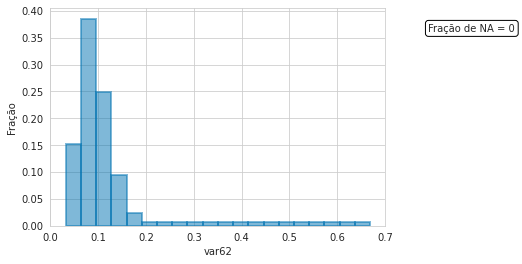

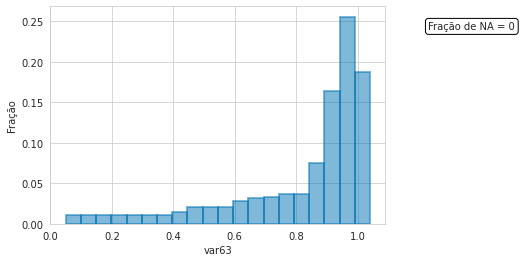

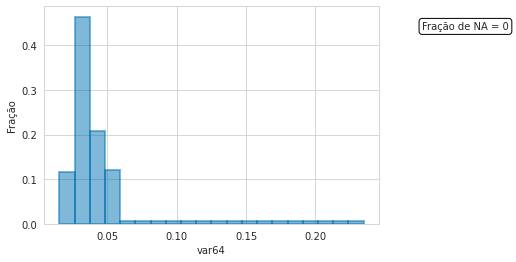

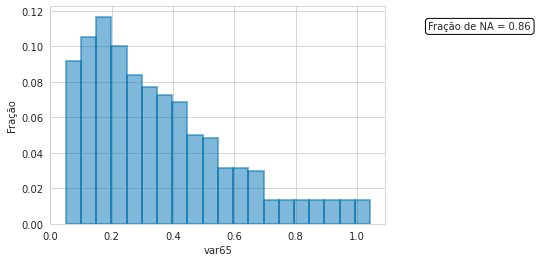

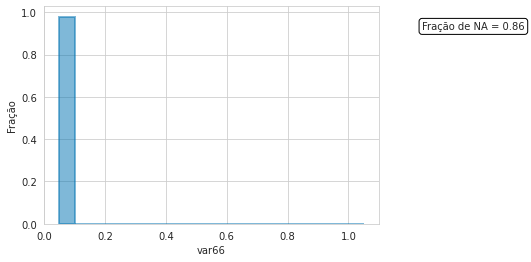

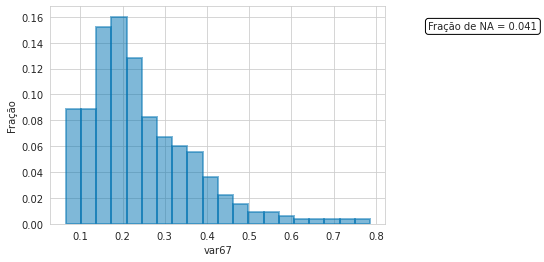

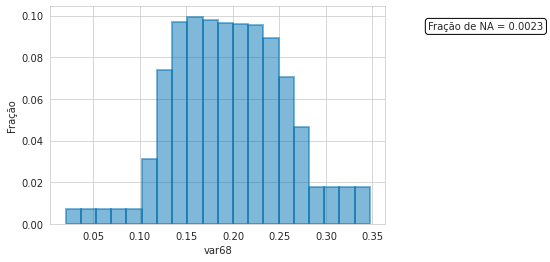

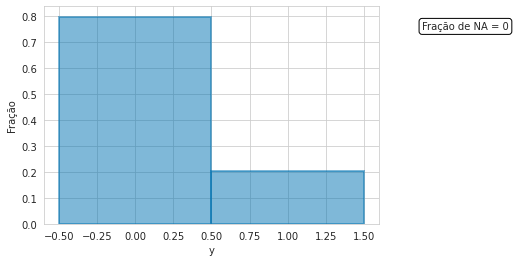

In [ ]:
analiseexp.grafico_distribuicao(bins = 20)

In [ ]:
alvo = 'y'

In [ ]:
colunas_id = ['id']

#Tratamento dos Nulos

In [ ]:
#dict(df.isna().sum() / len(df))

In [ ]:
cols_tot = df.drop(colunas_id, axis = 1).drop(alvo, axis = 1)
dict_imputer = {}
for col in cols_tot:
  df['nulo_' + col] = np.where(df[col].isna(), 1, 0)
  dict_imputer[col] = df[col].dropna().median()
  df[col] = df[col].fillna(dict_imputer[col])

# Separação do Teste (SAGRADO!)

In [ ]:
frac_teste = 0.1 #2/len(df)

ss_teste = StratifiedShuffleSplit(n_splits = 1, test_size = frac_teste, random_state = 42)
split_teste = list(ss_teste.split(df.values, df[alvo].values))[0] 

df_intermed = df.iloc[split_teste[0]]
df_teste = df.iloc[split_teste[1]]

In [ ]:
len(df_teste)

1413

# Separação Conjuntos Treino/Validação

In [ ]:
frac_val = 0.25
num_splits = 10

ss = StratifiedShuffleSplit(n_splits = num_splits, test_size = frac_val, random_state = 42)
#ss = StratifiedKFold(n_splits = num_splits, shuffle = True, random_state = 42)
lista_splits = list(ss.split(df_intermed.values, df_intermed[alvo].values))

In [ ]:
inverter_conjuntos = False

dict_Xy = {}

i = 0
for par in lista_splits:
    df_treino = df_intermed.iloc[par[0]]
    df_val = df_intermed.iloc[par[1]]
    
    dict_Xy.update({'Treino_' + str(i + 1): (df_treino.drop(colunas_id, axis = 1).drop(alvo, axis = 1), df_treino[alvo]),
               'Validacao_' + str(i + 1): (df_val.drop(colunas_id, axis = 1).drop(alvo, axis = 1), df_val[alvo])})
    
    if(inverter_conjuntos):
      tam = len(lista_splits)
      dict_Xy.update({'Treino_' + str(tam + i + 1): (df_val.drop(colunas_id, axis = 1).drop(alvo, axis = 1), df_val[alvo]),
                'Validacao_' + str(tam + i + 1): (df_treino.drop(colunas_id, axis = 1).drop(alvo, axis = 1), df_treino[alvo])})
    
    i = i + 1

In [ ]:
dict_Xy.keys()

dict_keys(['Treino_1', 'Validacao_1', 'Treino_2', 'Validacao_2', 'Treino_3', 'Validacao_3', 'Treino_4', 'Validacao_4', 'Treino_5', 'Validacao_5', 'Treino_6', 'Validacao_6', 'Treino_7', 'Validacao_7', 'Treino_8', 'Validacao_8', 'Treino_9', 'Validacao_9', 'Treino_10', 'Validacao_10'])

# Filtro de Features Instáveis entre os Conjuntos

In [ ]:
estabilidade_validacao = False

for i in range(0,int(len(dict_Xy)/2)):

  indices_temp = dict_Xy['Treino_'+str(i+1)][0].index
  analise_ig_temp = aml.AvaliaClassificacao(df_intermed.loc[indices_temp, :].drop(colunas_id, axis = 1), alvo, col_prob = None, num_div = 10, num_cat = 5)
  analise_ig_temp.calcula_metricas_condicionais(df_intermed.loc[indices_temp, :].drop(colunas_id, axis = 1))
  if(i == 0):
    df_igs = pd.DataFrame(analise_ig_temp.ganho_info(), columns = ['Treino_'+str(i+1)])
  else:
    df_igs = pd.concat((df_igs, pd.DataFrame(analise_ig_temp.ganho_info(), columns = ['Treino_'+str(i+1)])), axis = 1)

  if(estabilidade_validacao):
    indices_temp = dict_Xy['Validacao_'+str(i+1)][0].index
    analise_ig_temp = aml.AvaliaClassificacao(df_intermed.loc[indices_temp, :].drop(colunas_id, axis = 1), alvo, col_prob = None, num_div = 10, num_cat = 5)
    analise_ig_temp.calcula_metricas_condicionais(df_intermed.loc[indices_temp, :].drop(colunas_id, axis = 1))
    df_igs = pd.concat((df_igs, pd.DataFrame(analise_ig_temp.ganho_info(), columns = ['Validacao_'+str(i+1)])), axis = 1)

media = df_igs.mean(axis = 1)
desvio = df_igs.std(axis = 1)
df_igs['Media'] = media
df_igs['Desvio'] = desvio
df_igs['CoefVariacao'] = desvio/media
df_igs = df_igs[['Media', 'Desvio', 'CoefVariacao']]
df_igs = df_igs.loc[df_igs.index != alvo, :]

df_igs = df_igs.sort_values('Media', ascending = False)

In [ ]:
df_igs.style

,Media,Desvio,CoefVariacao
var4,0.161538,0.009535,0.059028
nulo_var8,0.109601,0.003324,0.030333
nulo_var6,0.048851,0.002387,0.048863
nulo_var7,0.048481,0.002483,0.051220
var20,0.043399,0.001751,0.040356
var6,0.039533,0.002554,0.064599
var23,0.037916,0.001590,0.041934
var54,0.034194,0.002494,0.072946
var8,0.033866,0.001823,0.053820
var1,0.031986,0.002007,0.062739


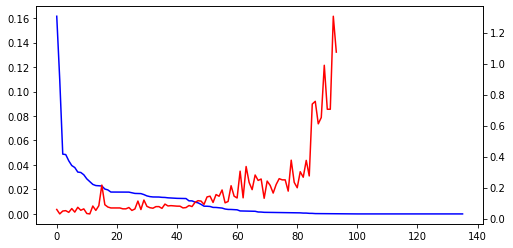

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (8, 4))
ax.plot(df_igs['Media'].values, color = 'blue')
ax2 = ax.twinx()
ax2.plot(df_igs['CoefVariacao'].values, color = 'red')
plt.show()

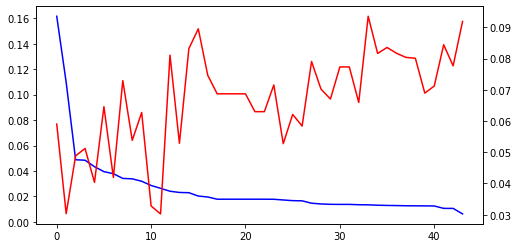

['var4', 'nulo_var8', 'nulo_var6', 'nulo_var7', 'var20', 'var6', 'var23', 'var54', 'var8', 'var1', 'var14', 'nulo_var4', 'var53', 'var5', 'var24', 'var56', 'var16', 'nulo_var18', 'nulo_var17', 'nulo_var16', 'nulo_var15', 'nulo_var58', 'nulo_var26', 'var29', 'var58', 'var22', 'var59', 'var15', 'var11', 'var28', 'nulo_var52', 'nulo_var9', 'var52', 'var26', 'var17', 'var12', 'nulo_var59', 'nulo_var57', 'nulo_var56', 'nulo_var11', 'var7', 'nulo_var12', 'nulo_var10', 'var34']
44


In [ ]:
num_max_features = 85
limiar_coef_var = 0.10

df_igs_filter = df_igs.iloc[:num_max_features]
df_igs_filter = df_igs_filter[(df_igs_filter['CoefVariacao'] <= limiar_coef_var) & (~df_igs_filter['CoefVariacao'].isna())]

fig, ax = plt.subplots(1, 1, figsize = (8, 4))
ax.plot(df_igs_filter['Media'].values, color = 'blue')
ax2 = ax.twinx()
ax2.plot(df_igs_filter['CoefVariacao'].values, color = 'red')
plt.show()

cols_modelo = list(df_igs_filter.index)
print(cols_modelo)
print(len(cols_modelo))

In [ ]:
dict_Xy_modelo = dict_Xy.copy()

for key in dict_Xy_modelo.keys():
  dict_Xy_modelo[key] = (dict_Xy_modelo[key][0][cols_modelo], dict_Xy_modelo[key][1])

# Random

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
from sklearn.metrics import f1_score

def get_best_probcut(y_real, y_prob):

  interv = trf.CortaIntervalosQuasiUniforme(y_prob, num_div = 200)
  y_prob = interv.aplica_discretizacao(y_prob)

  ind_order = np.argsort(y_prob)
  y_prob_ord = y_prob[ind_order]
  y_real_ord = y_real[ind_order]

  probs_unicos = np.unique(y_prob)
  f1_list = []
  for p in probs_unicos:
    y_pred = (y_prob > p).astype(int)
    f1 = f1_score(y_real, y_pred)
    f1_list.append(f1)

  ind_max = np.argmax(np.array(f1_list))
  prob_max = probs_unicos[ind_max]

  prob_max = (interv.info_discretizacao().loc[int(prob_max), 'Max'] + interv.info_discretizacao().loc[int(prob_max), 'Min'])/2
  return prob_max

In [ ]:
def get_best_rf_clf(X_treino, y_treino, X_val, y_val, max_depth, n_estimators, max_features, frac_per_leaf, verbose = True, random_state = 42, metrica = 'Logloss'):

  vetor_metrica_treino = np.array([])
  vetor_metrica_val    = np.array([])

  min_sample_leaf = max(round(frac_per_leaf * len(X_treino)),1)
  min_sample_split = max(min_sample_leaf, 2)

  for i in range(1, max_depth):

    clf = RandomForestClassifier(max_depth = i,
                                    n_estimators = n_estimators ,
                                    max_features = max_features,
                                    min_samples_split = min_sample_split,
                                    min_samples_leaf = min_sample_leaf,
                                    criterion = 'entropy',
                                    random_state = random_state)
    
    clf.fit(X_treino, y_treino)
  
    # Calcula a métrica

    if metrica == 'F1':
      
      # Calcular a Prob de corte
      prob_cut = get_best_probcut(y_treino.values, clf.predict_proba(X_treino)[:, 1])
      
      metrica_treino = f1_score(y_treino, (clf.predict_proba(X_treino)[:, 1]> prob_cut).astype(int))
      
      metrica_val = f1_score(y_val, (clf.predict_proba(X_val)[:, 1] > prob_cut).astype(int))

    if metrica == 'Logloss':
      metrica_treino = log_loss(y_treino, clf.predict_proba(X_treino)[:, 1]) * (-1)
      metrica_val = log_loss(y_val, clf.predict_proba(X_val)[:, 1]) * (-1)


    vetor_metrica_treino = np.append(vetor_metrica_treino, metrica_treino)
    vetor_metrica_val = np.append(vetor_metrica_val, metrica_val)
    
    if (i == 1):
      melhor_i = i
      melhor_clf = clf
      melhor_metrica = metrica_val
    elif (metrica_val > melhor_metrica):
      melhor_i = i
      melhor_clf = clf
      melhor_metrica = metrica_val

    if verbose == True:
      print('max_depth: {}'.format(i))
      print('{} Treino: {}'.format(metrica, metrica_treino))
      print('{} Validação: {}'.format(metrica, metrica_val))

  figsize = [8,6]
  paleta_cores = sns.color_palette("colorblind")
  with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(1,1, figsize = figsize)
    axs.plot(vetor_metrica_treino, color = paleta_cores[0], label = 'Treino')
    axs.plot(vetor_metrica_val, color = paleta_cores[1], label = 'Validação')
    axs.scatter(melhor_i - 1, melhor_metrica)
    axs.set_xlabel('Complexidade')
    axs.set_ylabel('metrica')
    axs.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.show()
  
  return clf

In [ ]:
clf_list = []

for i in range(0,int(len(dict_Xy_modelo)/2)):

  clf = get_best_rf_clf(dict_Xy_modelo['Treino_'+str(i+1)][0], dict_Xy_modelo['Treino_'+str(i+1)][1], 
                        dict_Xy_modelo['Validacao_'+str(i+1)][0], dict_Xy_modelo['Validacao_'+str(i+1)][1], 
                        max_depth = 15, n_estimators= 100, max_features = 30, frac_per_leaf = 0.05, verbose = False, random_state = 15, metrica = 'F1')


  clf_list.append(clf)

  #plt.plot(clf.evals_result_['validation_0']['Logloss'])
  #plt.plot(clf.evals_result_['validation_1']['Logloss'])
  #plt.vlines(clf.get_best_iteration(), 0, 0.6)
  #plt.show()

In [ ]:
class EnsembleClassifier():

  def __init__(self, clf_list):
    self.clf_list = clf_list

  def predict_proba(self, X):
    return reduce(lambda x, y: x+y, [clf.predict_proba(X) for clf in self.clf_list]) / len(self.clf_list)

In [ ]:
clf_ens = EnsembleClassifier(clf_list)

# Avaliação

In [ ]:
probs_intermed = clf_ens.predict_proba(df_intermed[cols_modelo])[:, 1]
probs_teste = clf_ens.predict_proba(df_teste[cols_modelo])[:, 1]

In [ ]:
df_intermed_aval = df_intermed.copy()
df_teste_aval = df_teste.copy()

df_intermed_aval['Prob'] = probs_intermed
df_teste_aval['Prob'] = probs_teste

In [ ]:
dict_dfs = {'Treino': df_intermed_aval,
            'Teste': df_teste_aval}
avaliacaoclf = aml.AvaliaDatasetsClassificacao(dict_dfs, 
                                               alvo, 
                                               'Prob', 
                                               num_div_prob = 100, 
                                               num_div = 10, 
                                               num_cat = 5, 
                                               unit = None, 
                                               chave_treino = 'Treino')

,Treino,Teste
LogLoss,0.318166,0.334372
CoefLogLoss,0.367339,0.334911
CoefLogLoss_ref,0.367339,0.334912
AUC,0.895862,0.864446
KS,0.622362,0.572760
IG,0.274637,0.280236
IG_2D,0.351636,0.315120
Frac_Incerto_2D,0.299843,0.298655
Prob_Corte,0.175581,0.395691
Prob0_Corte,0.121586,0.060252


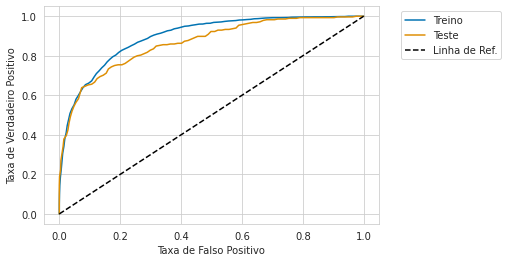

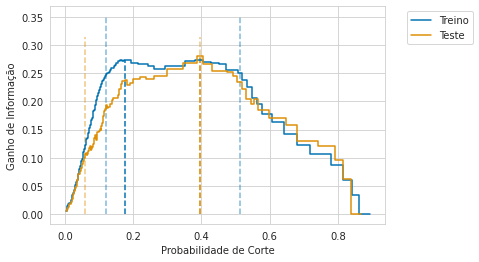

In [ ]:
df_metricas = avaliacaoclf.valor_metricas().loc[['LogLoss', 'CoefLogLoss', 'CoefLogLoss_ref',
                                  'AUC', 'KS', 'IG', 'IG_2D', 'Frac_Incerto_2D', 
                                  'Prob_Corte', 'Prob0_Corte', 'Prob1_Corte',
                                  'Acurácia_Balanceada', 'Acurácia_Balanceada_2D',
                                  'P(0|0)', 'P_2D(0|0)', 'Frac_0',
                                  'P(1|1)', 'P_2D(1|1)', 'Frac_1'], :]

display(df_metricas)

avaliacaoclf.grafico_roc()
avaliacaoclf.grafico_informacao(mostrar_ig_2d = True)

In [ ]:
p_corte = df_metricas.loc['Prob_Corte', 'Treino']
print(p_corte)

print('Treino:')
display(f1_score(df_intermed_aval[alvo].values, (df_intermed_aval['Prob'].values > p_corte).astype(int)))
print('Teste:')
display(f1_score(df_teste_aval[alvo].values, (df_teste_aval['Prob'].values > p_corte).astype(int)))

0.1755813251721009
Treino:


0.6360676073809892

Teste:


0.6153846153846153

In [ ]:
p_corte_f1 = get_best_probcut(df_intermed_aval[alvo].values , df_intermed_aval['Prob'].values)
print(p_corte_f1)

print('Treino:')
display(f1_score(df_intermed_aval[alvo].values, (df_intermed_aval['Prob'].values > p_corte_f1).astype(int)))
print('Teste:')
display(f1_score(df_teste_aval[alvo].values, (df_teste_aval['Prob'].values > p_corte_f1).astype(int)))

0.4068627590411693
Treino:


0.6583551176352301

Teste:


0.663023679417122

In [ ]:
#joblib.dump(clf_ens, path_notebook + 'clf_ens_ale.pkl')

In [ ]:
#clf_ens = joblib.load(path_notebook + 'clf_ens_ale.pkl')

# Explicabilidade

In [ ]:
explic_imp = exp.ImportanciaVariaveisClassificacao(clf_ens, df_intermed, alvo, cols_features = cols_modelo, num_loop = 5, random_state = 42)

In [ ]:
df_logloss = pd.DataFrame(pd.Series(explic_imp.retorna_piora_logloss()), columns = ['Piora_Logloss'])
df_logloss['Incerteza'] = explic_imp.retorna_incertezas_piora()
df_logloss = df_logloss.sort_values('Piora_Logloss', ascending = False)

<BarContainer object of 15 artists>

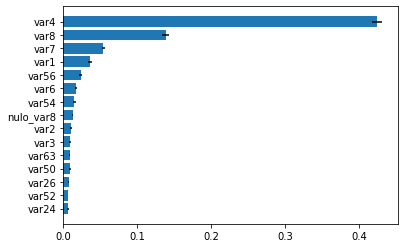

In [ ]:
n_plot = 15
plt.barh(df_logloss.index[:n_plot][::-1], df_logloss[:n_plot]['Piora_Logloss'][::-1], xerr = df_logloss[:n_plot]['Incerteza'][::-1])

In [ ]:
for col in df_logloss.index[:n_plot]:
  avaliacaoclf.calcula_metricas_condicionais(dict_dfs, col)

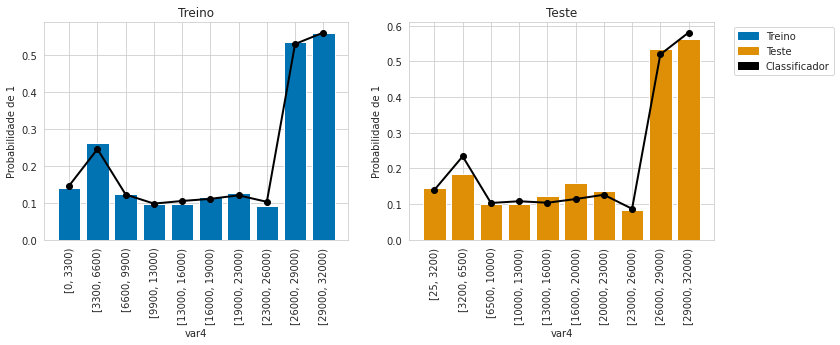

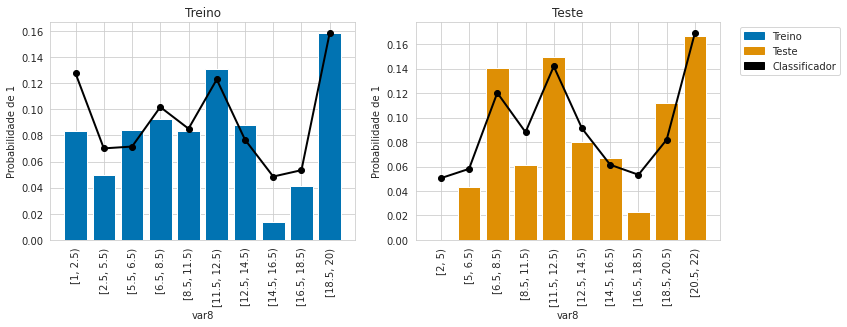

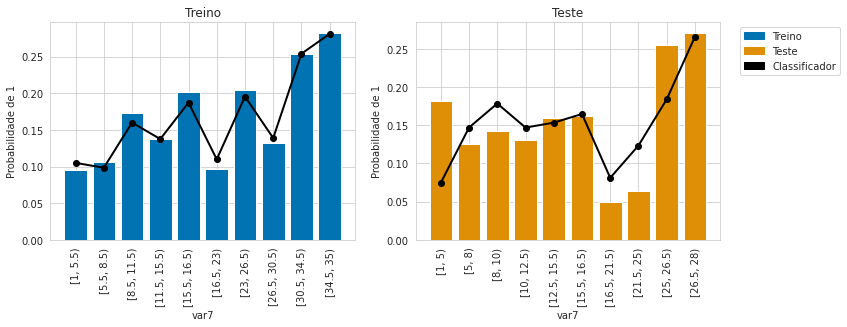

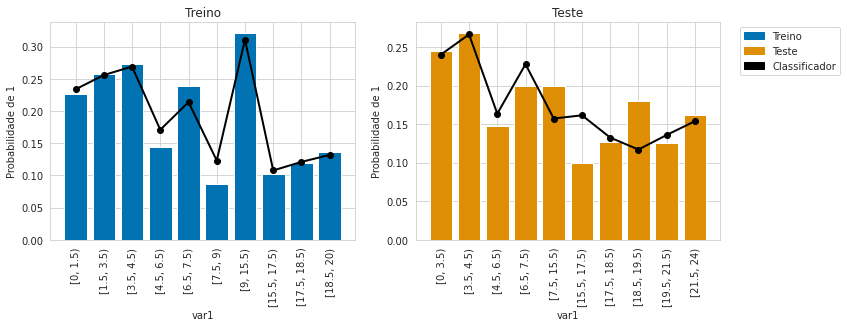

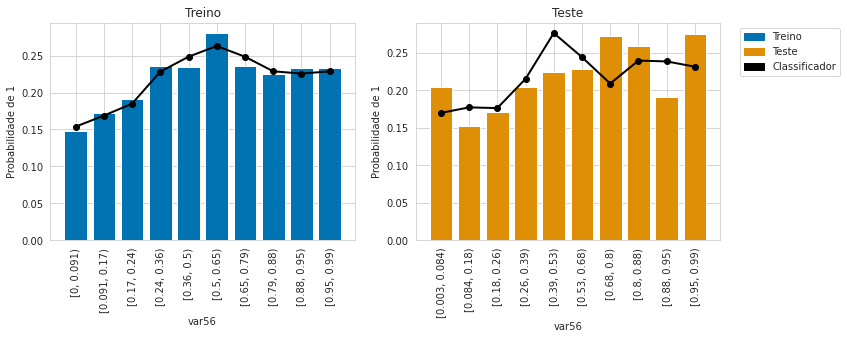

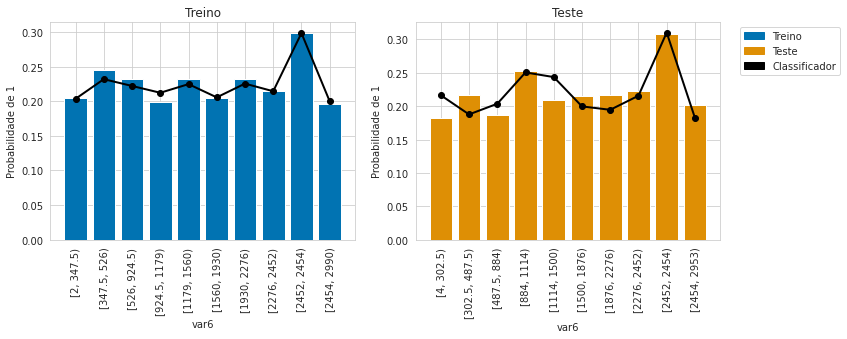

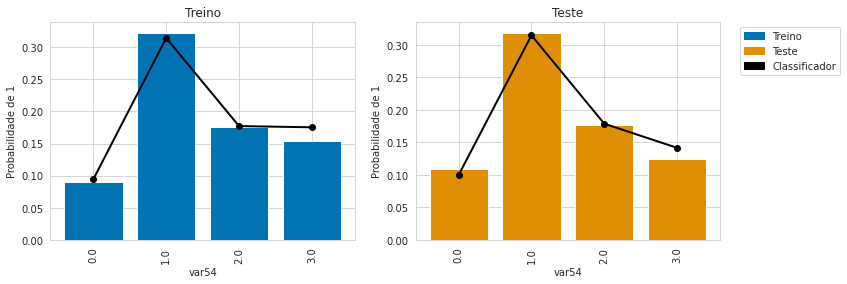

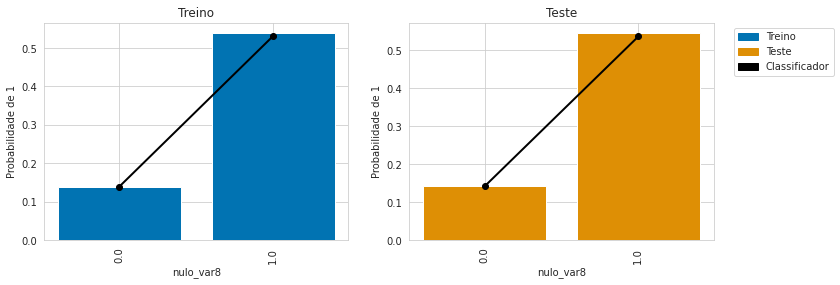

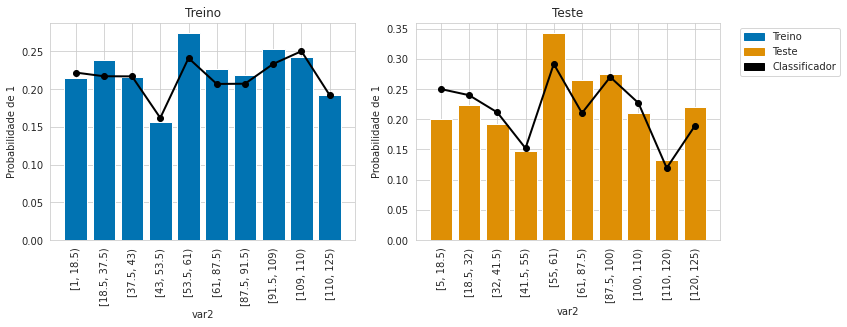

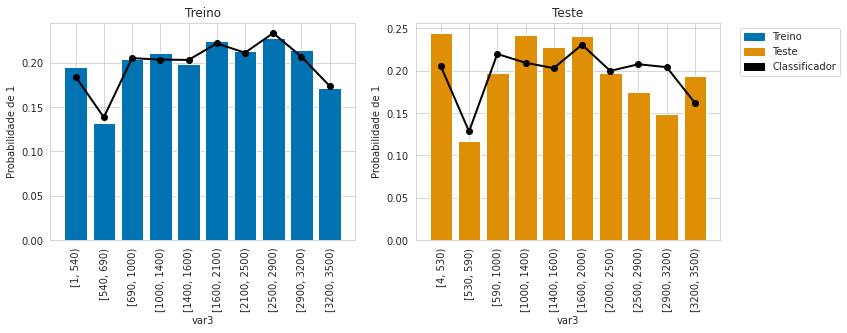

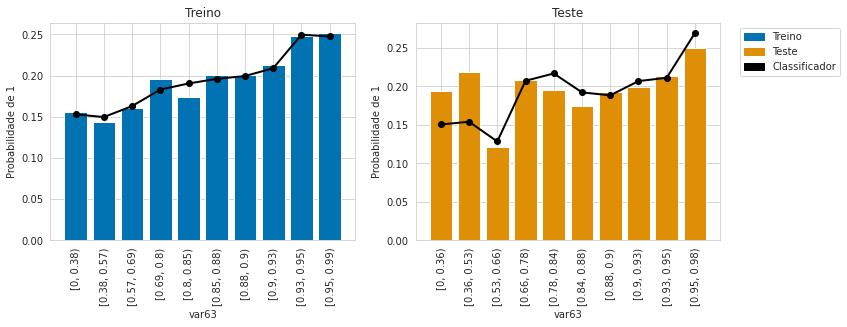

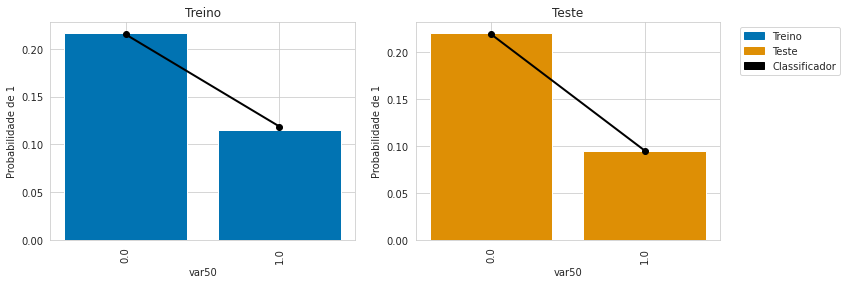

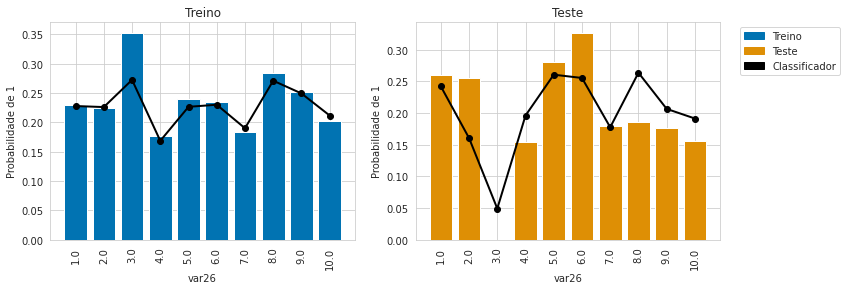

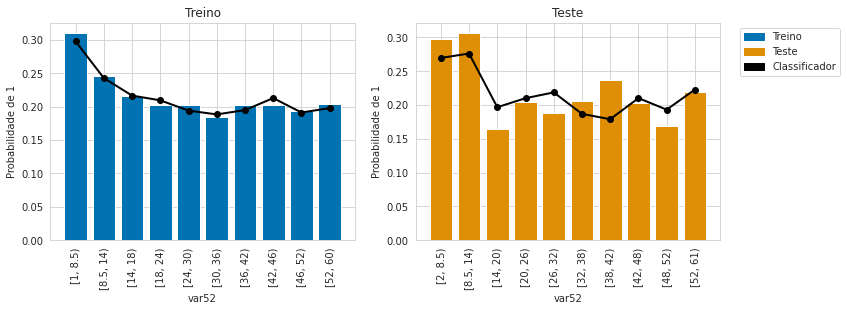

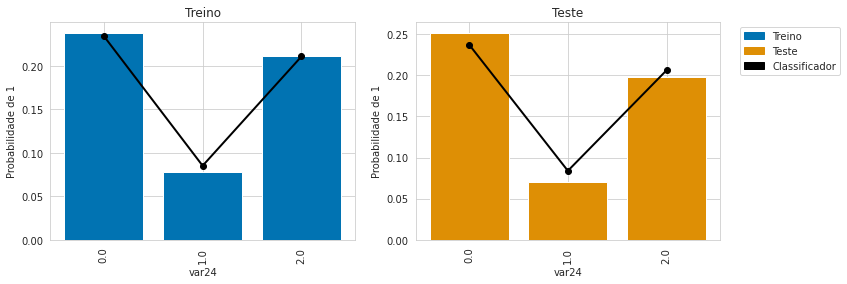

In [ ]:
for col in df_logloss.index[:n_plot]:
  avaliacaoclf.grafico_probabilidade_condicional(col, rot = 90)

# Submissão

In [ ]:
df_test = pd.read_csv('test.csv.zip')
len(df_test)

21183

In [ ]:
df_test[df_test == -999] = np.nan

#### Diferença dos Datasets

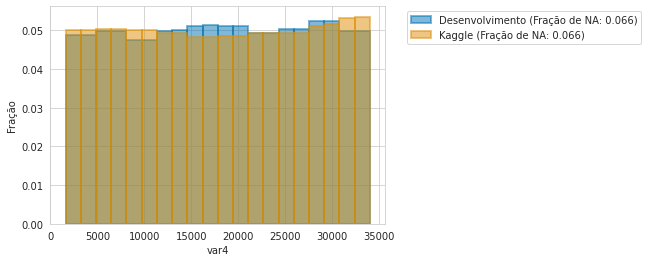

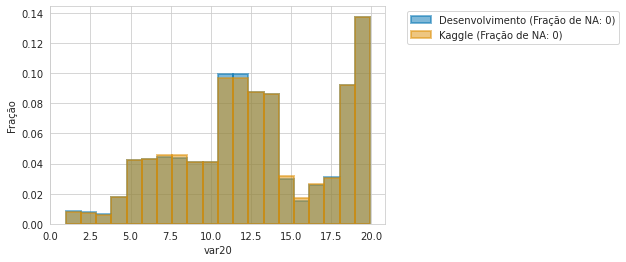

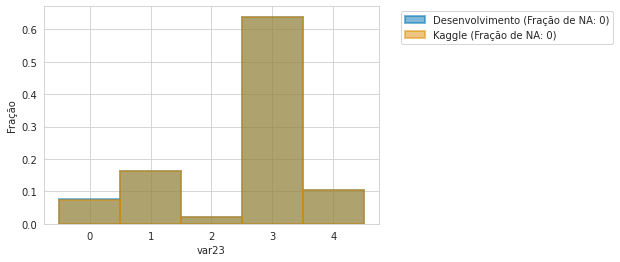

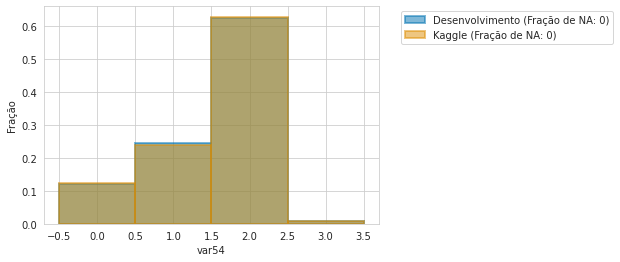

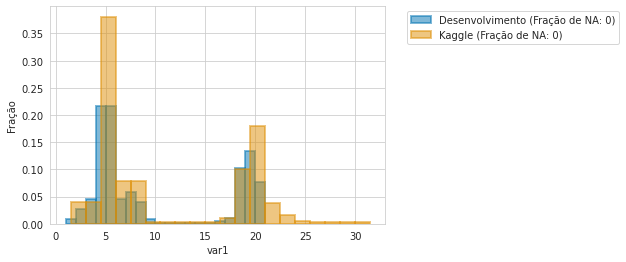

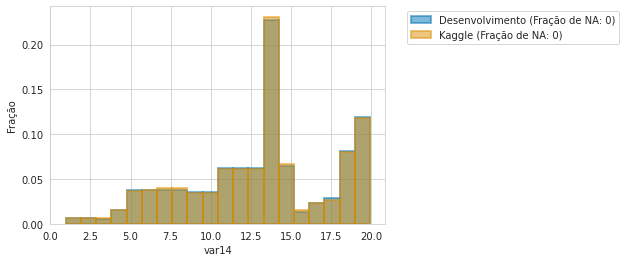

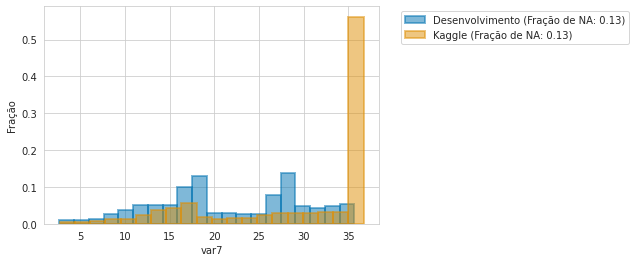

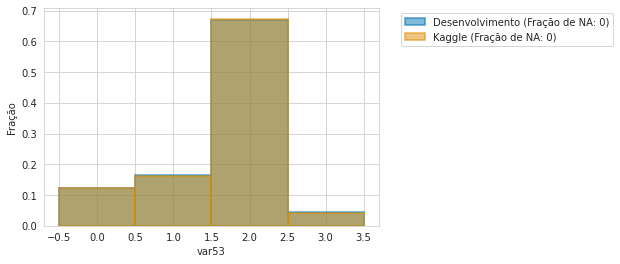

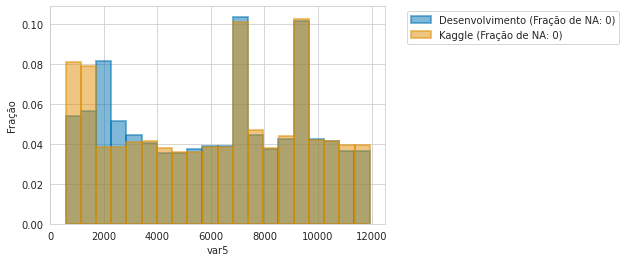

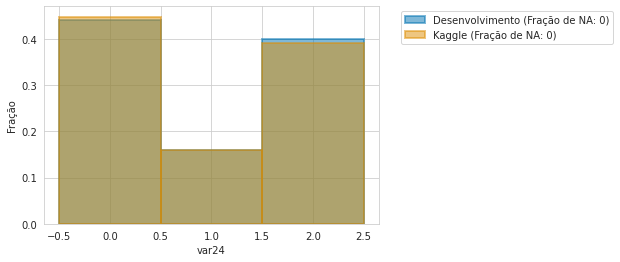

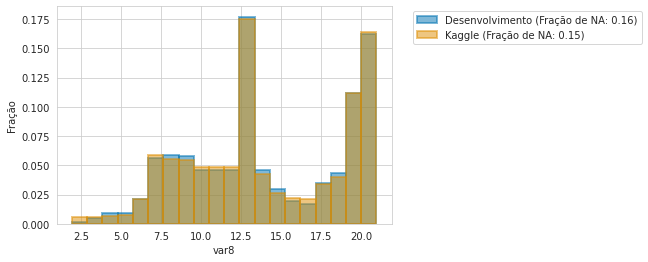

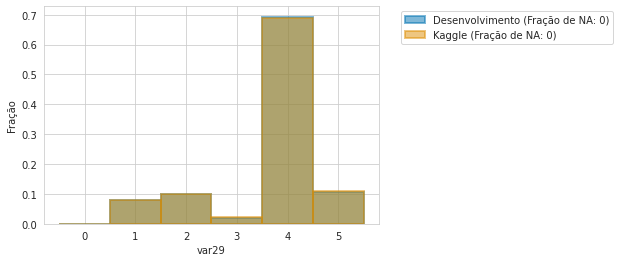

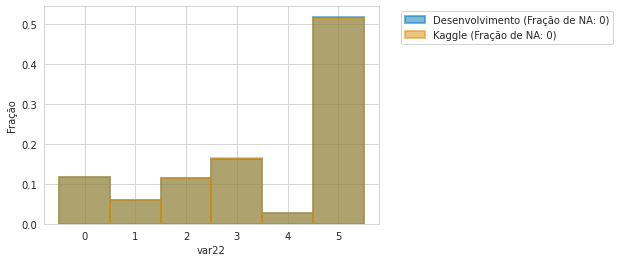

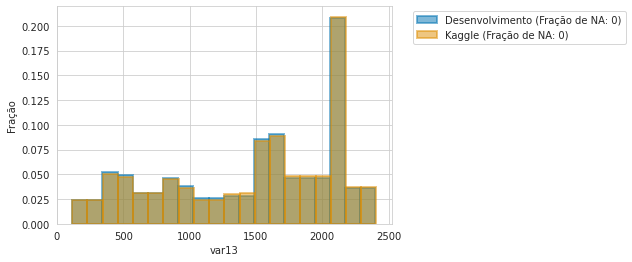

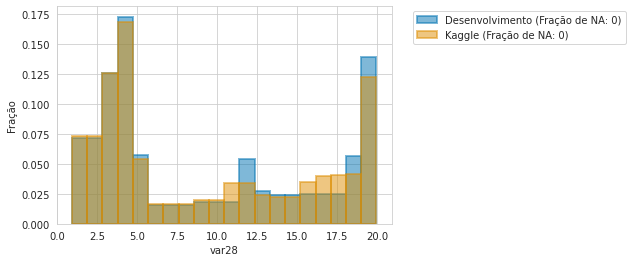

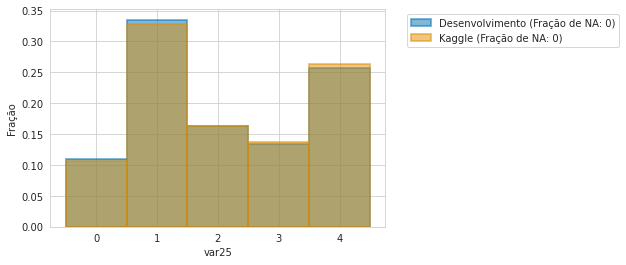

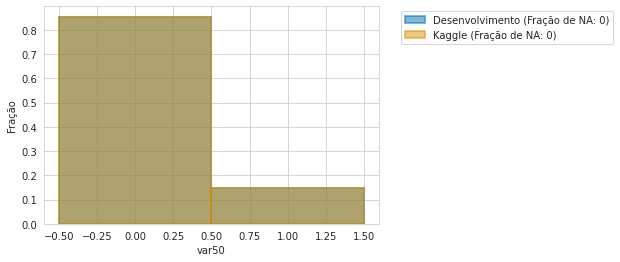

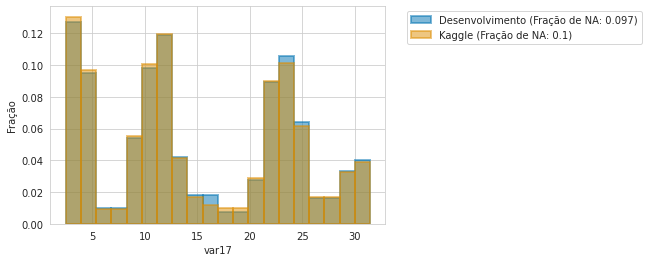

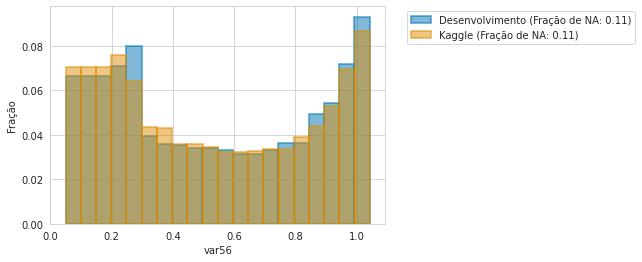

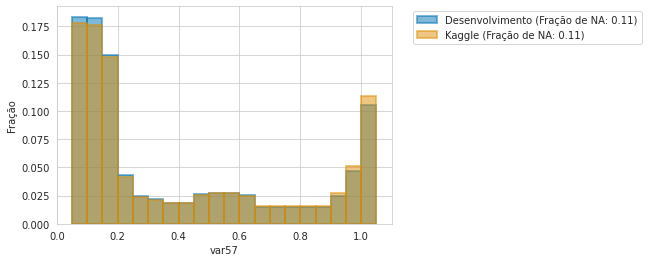

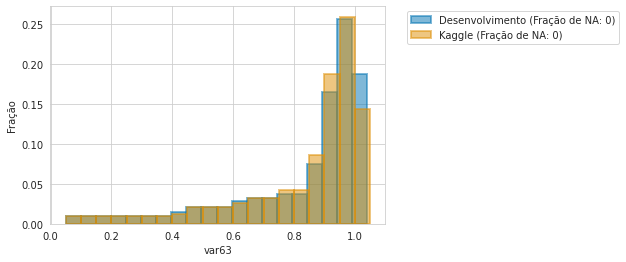

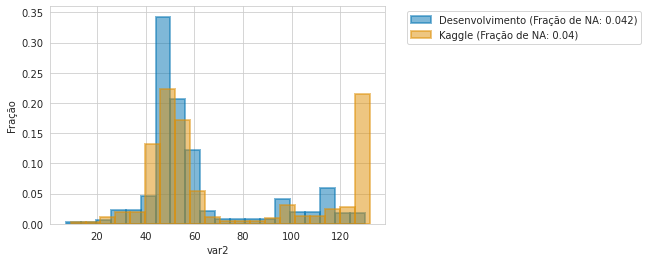

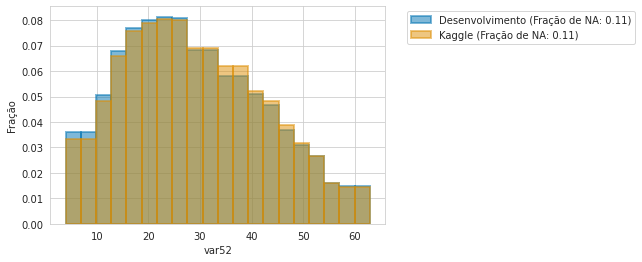

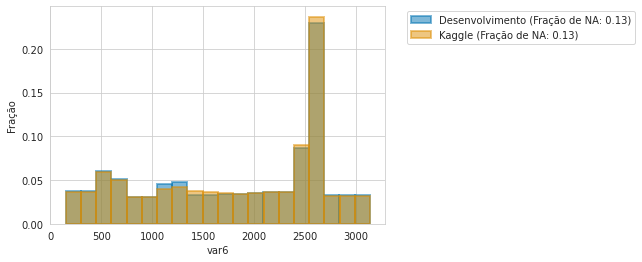

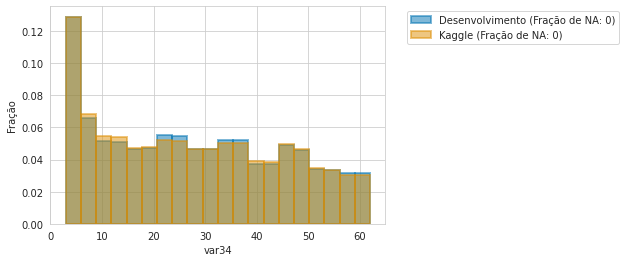

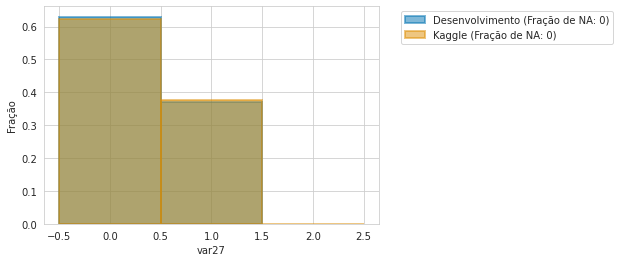

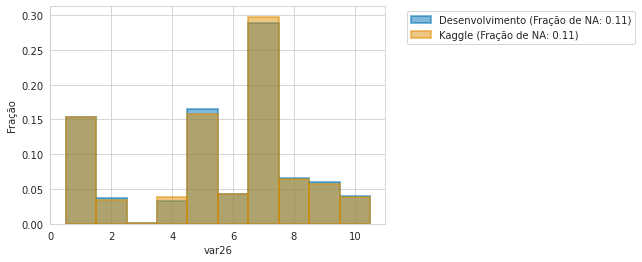

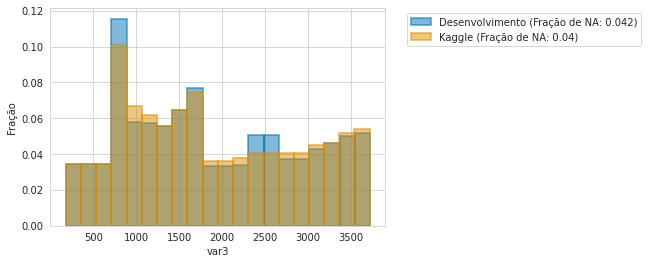

In [ ]:
compara_datasets = dat.AvaliaDatasetsDistribuicoes({'Desenvolvimento': df[[c for c in cols_modelo if c[:4] != 'nulo']], 
                                                    'Kaggle': df_test[[c for c in cols_modelo if c[:4] != 'nulo']]}, num_div = 10, num_cat = 5, autorun = True)
compara_datasets.grafico_distribuicao(bins = 20)

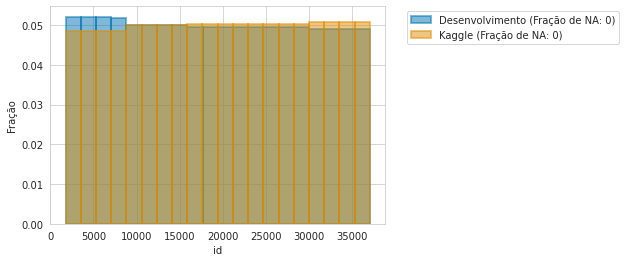

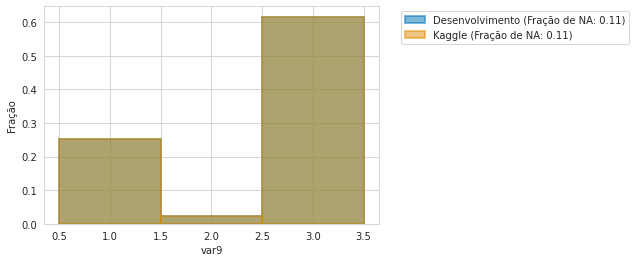

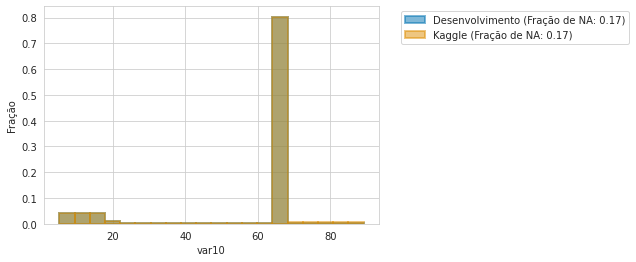

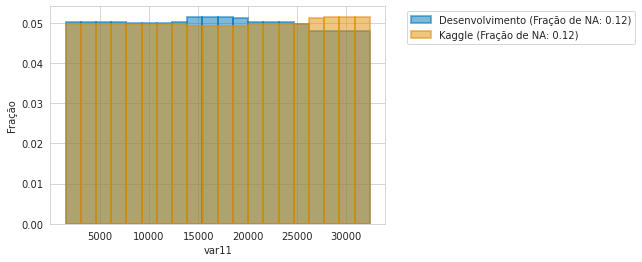

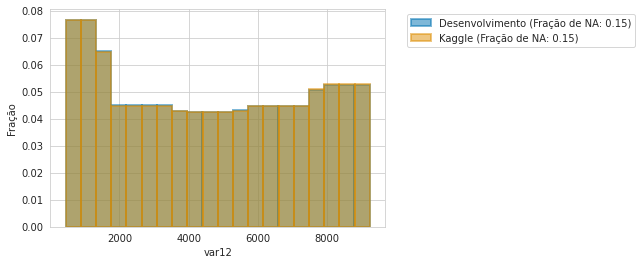

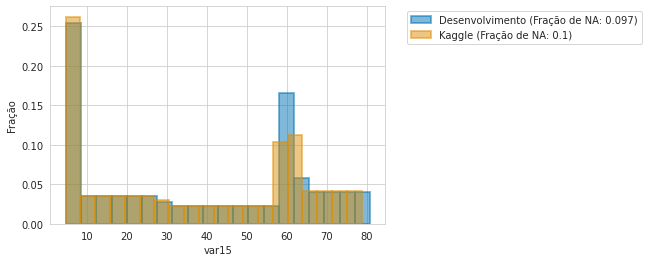

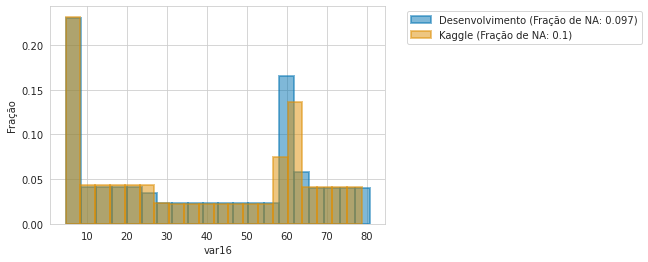

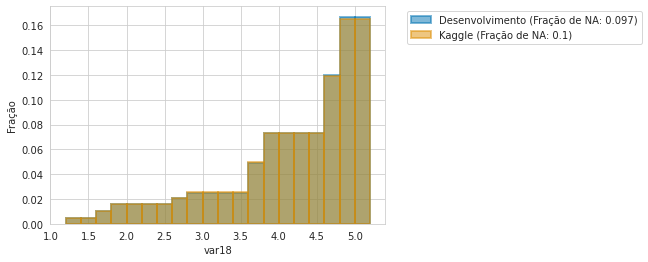

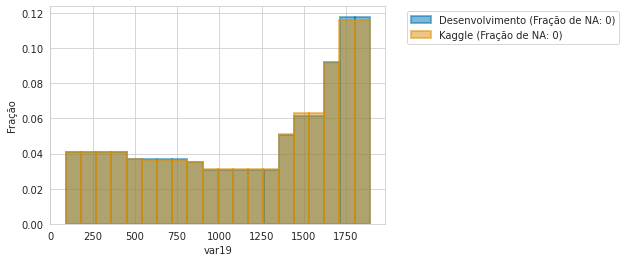

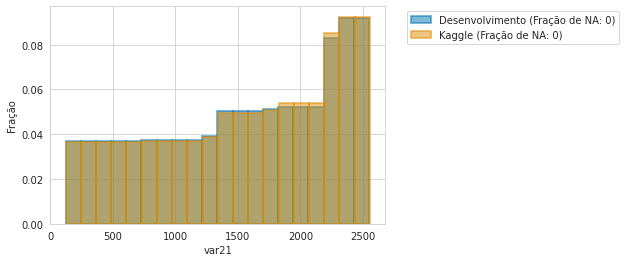

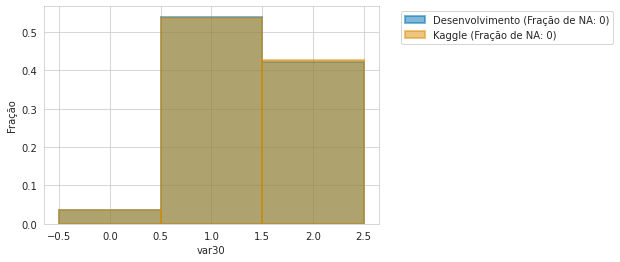

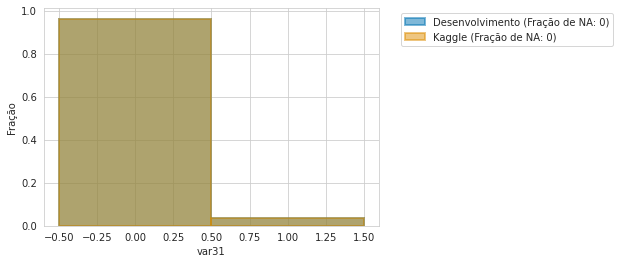

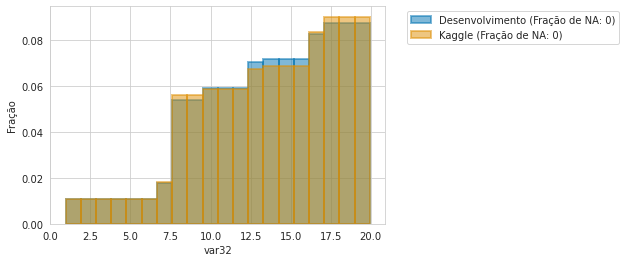

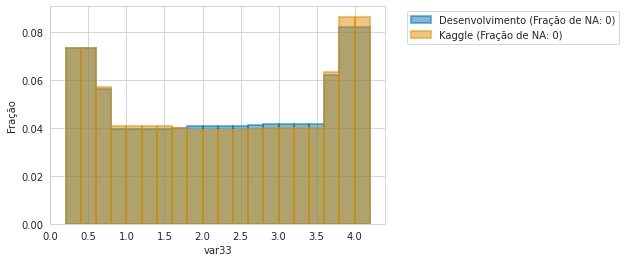

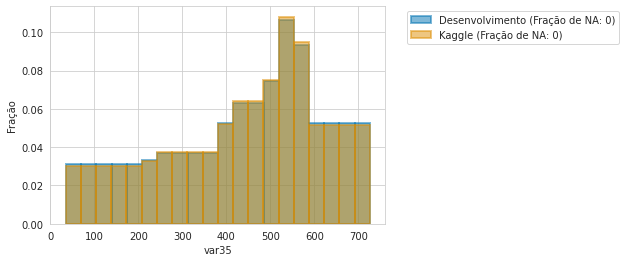

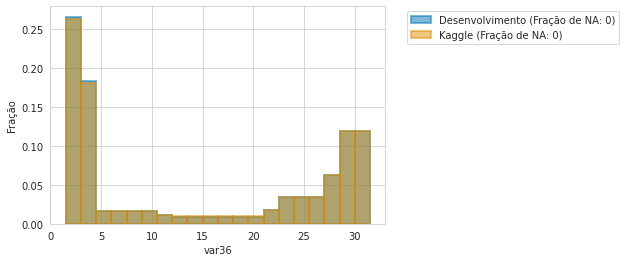

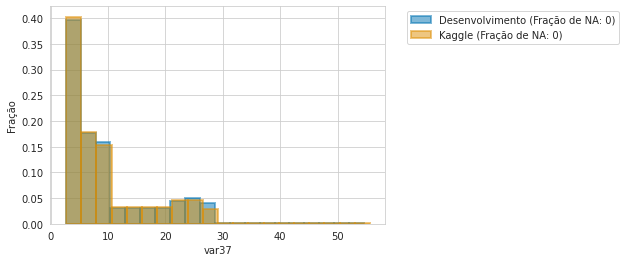

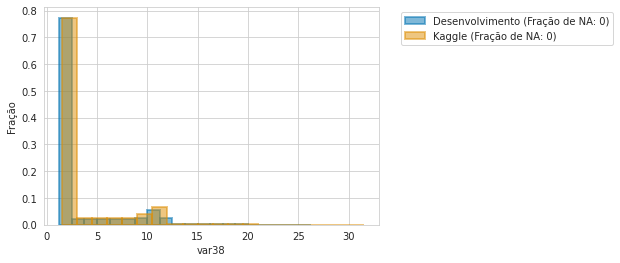

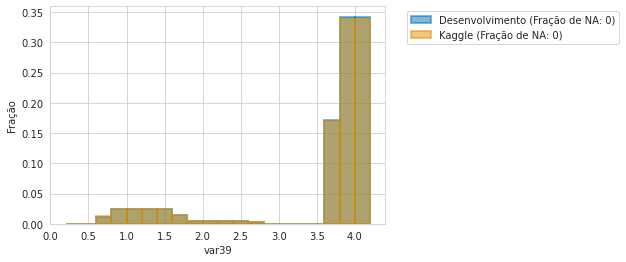

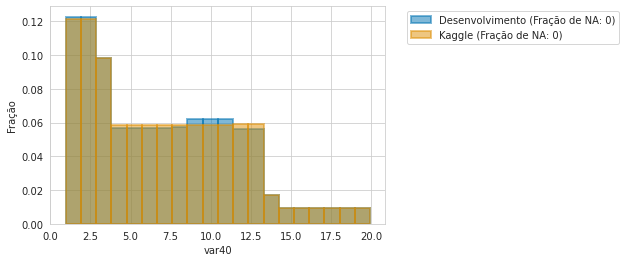

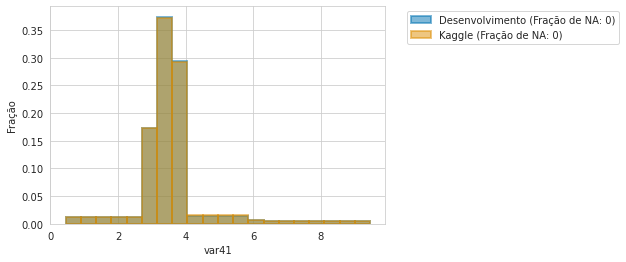

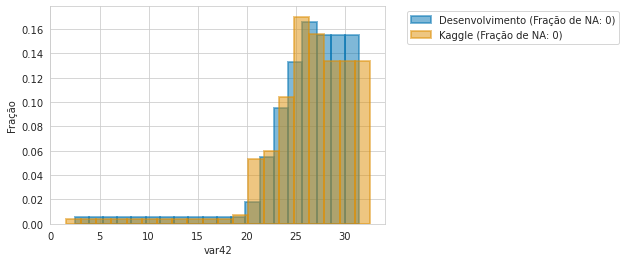

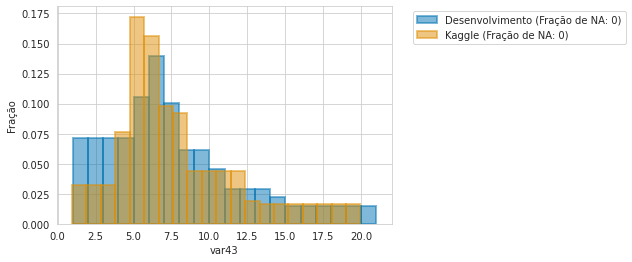

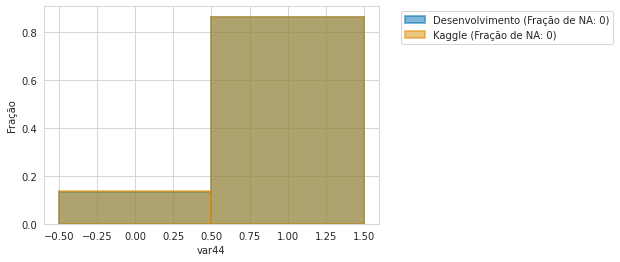

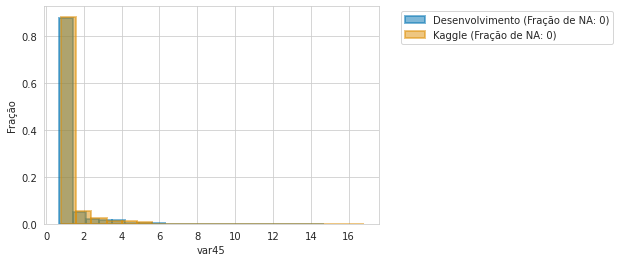

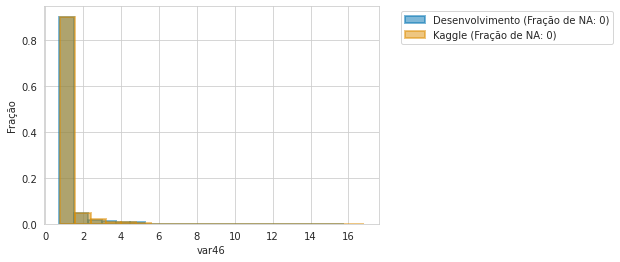

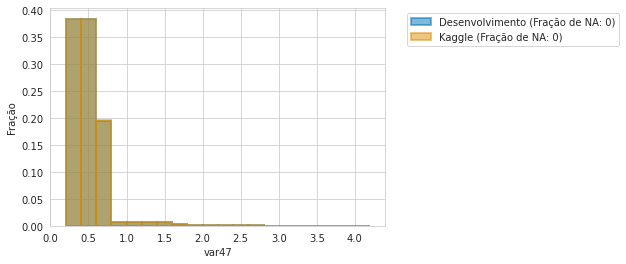

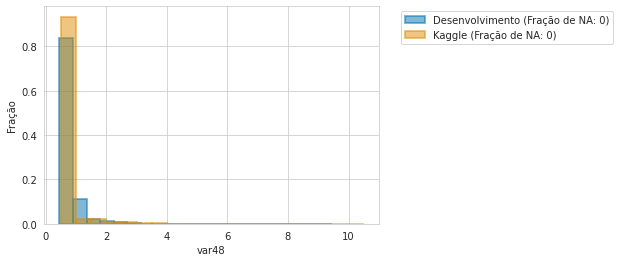

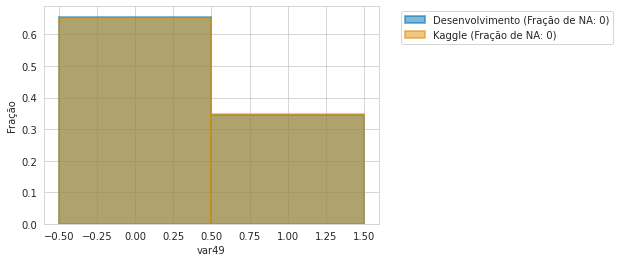

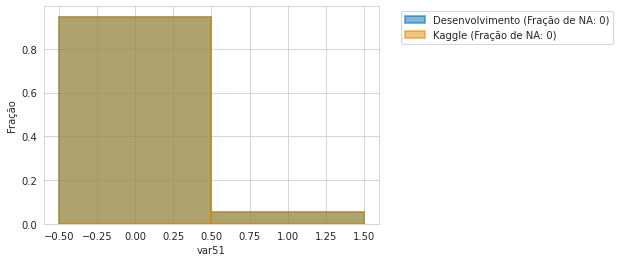

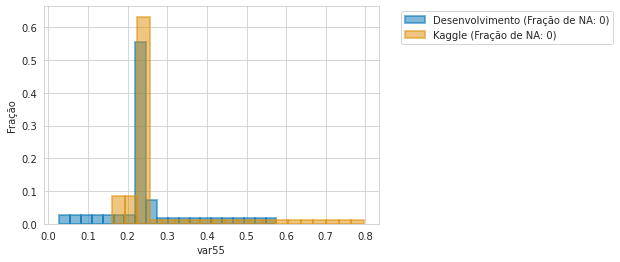

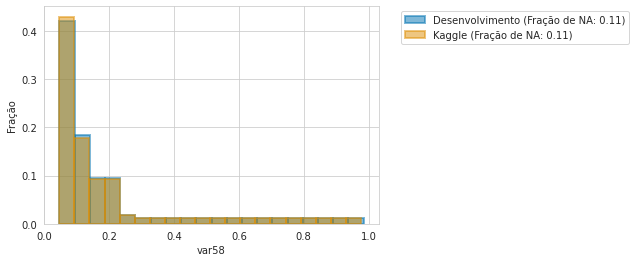

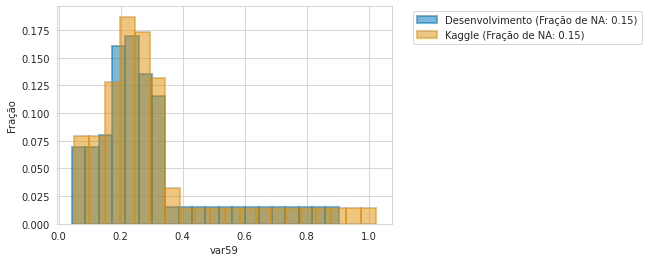

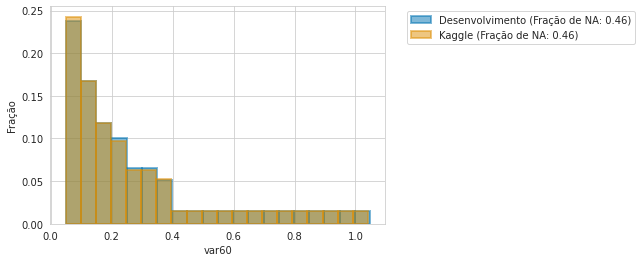

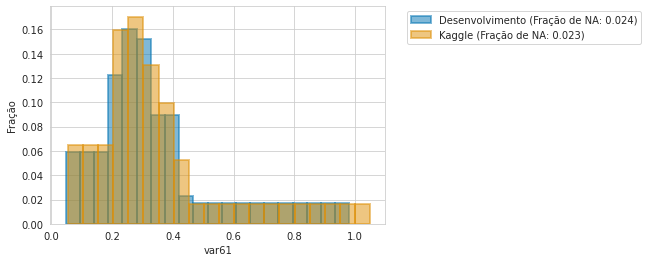

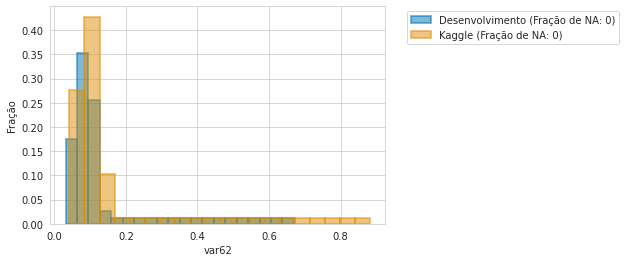

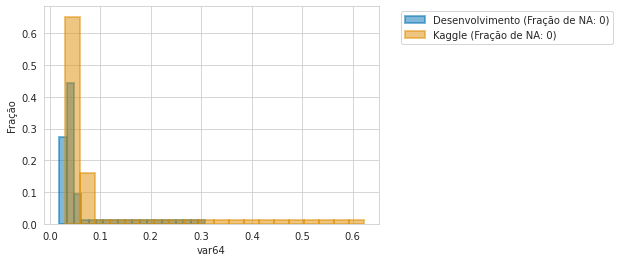

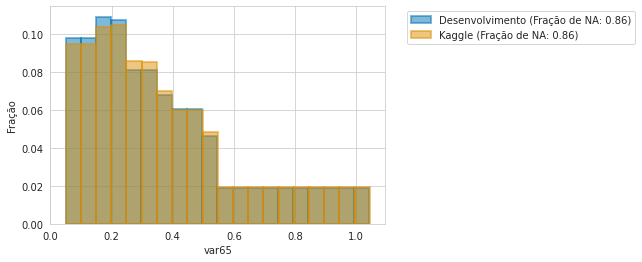

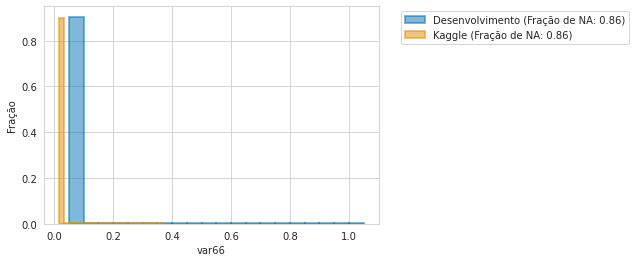

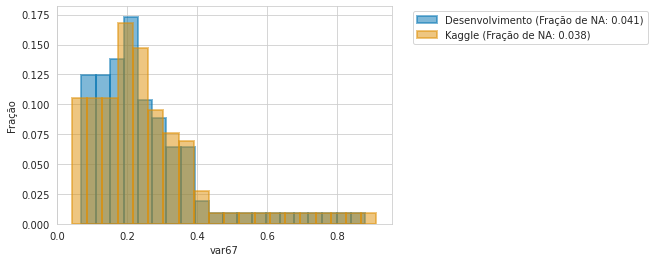

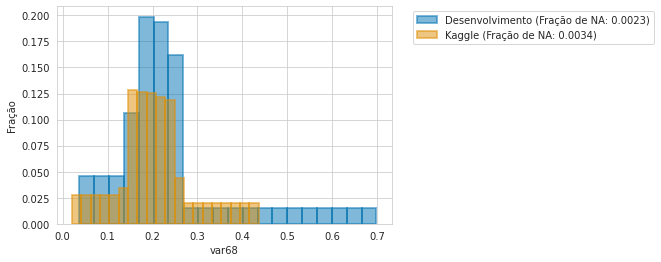

TypeError: ignored

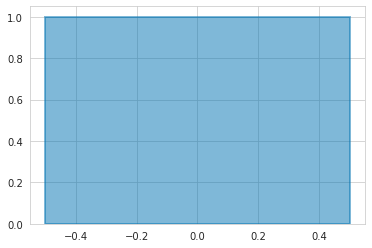

In [ ]:
compara_datasets = dat.AvaliaDatasetsDistribuicoes({'Desenvolvimento': df.drop([c for c in cols_modelo if c[:4] != 'nulo'], axis = 1).drop(alvo, axis = 1), 
                                                    'Kaggle': df_test.drop([c for c in cols_modelo if c[:4] != 'nulo'], axis = 1)}, num_div = 5, num_cat = 5, autorun = True)
compara_datasets.grafico_distribuicao(bins = 20)

#### predição

In [ ]:
for col in cols_tot:
  df_test['nulo_' + col] = np.where(df_test[col].isna(), 1, 0)
  #df_test[col] = df_test[col].fillna(dict_imputer[col])

In [ ]:
probs_test = clf_ens.predict_proba(df_test.drop(colunas_id, axis = 1)[cols_modelo])[:, 1]

In [ ]:
#pred_test = (probs_test > p_corte).astype(int)
pred_test = (probs_test > p_corte_f1).astype(int)

In [ ]:
df_sub = df_test[['id']].copy()
df_sub['predicted'] = pred_test
df_sub.to_csv(path_notebook + 'submission_featureselection_ale.csv',index = False)
df_sub.to_csv('submission_featureselection_ale.csv',index = False)

In [ ]:
!kaggle competitions submit -c porto-seguro-data-challenge -f submission_featureselection_ale.csv -m 'nosso baseline'

100% 159k/159k [00:00<00:00, 515kB/s]
400 - Bad Request
